### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com 


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']


In [2]:
from datetime import datetime, timedelta
import os
import yaml
import sqlite3
import json
from collections import Counter
import uuid
from typing import TypedDict, Annotated
import subprocess
import requests
import re

import operator
import pickle

import langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

from langchain_core.output_parsers import SimpleJsonOutputParser, JsonOutputParser, StrOutputParser

from langgraph.graph import StateGraph, START, END

from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

import numpy as np
import pandas as pd
import umap

import sklearn
from sklearn.cluster import DBSCAN

import bs4
from urllib.parse import urljoin, urlparse

import multiprocessing
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

import pyperclip
import shlex

import openai
from openai import OpenAI

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

import pdb

import dotenv
VERBOSE=1
from ainb_const import (DOWNLOAD_DIR, PAGES_DIR,
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT, 
                        TOP_CATEGORIES_PROMPT, TOPIC_REWRITE_PROMPT, REWRITE_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB,
                        HOSTNAME_SKIPLIST, SITE_NAME_SKIPLIST, TOPSOURCES
                       )
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article,
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file,
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory,
                            process_url_queue_factory, get_google_news_redirects)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, count_tokens, trunc_tokens, 
                      categorize_headline, categorize_df, clean_topics,
                      get_site_name, fetch_missing_site_names)


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")


Python            3.11.10 | packaged by conda-forge | (main, Sep 10 2024, 10:57:35) [Clang 17.0.6 ]
LangChain         0.3.3
OpenAI            1.52.0
trafilatura       1.12.2
numpy             1.26.4
pandas            2.2.3
sklearn           1.5.2
umap              0.5.6


# Test LLM calling

In [4]:
# a basic LLM call with langchain
model = ChatOpenAI(model=MODEL)

model.invoke([
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content='Listen to me. You are beautiful. You are perfect and I love you.'),
])


2024-11-09 17:50:54,126 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='Ascoltami. Sei bellissima. Sei perfetta e ti amo.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 34, 'total_tokens': 50, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'chatgpt-4o-latest', 'system_fingerprint': 'fp_e9e8eff3a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-cb941606-91fe-4c15-abd9-c9612f850e85-0', usage_metadata={'input_tokens': 34, 'output_tokens': 16, 'total_tokens': 50, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
# use a langchain template
system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)
parser = StrOutputParser()
chain = prompt_template | model | parser
chain.invoke({"language": "italian", "text": "hi"})


2024-11-09 17:50:54,605 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Ciao'

In [6]:
# time multiple templates (single-threaded)
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


2024-11-09 17:50:55,249 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.

2024-11-09 17:50:56,008 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hör mir zu. Du bist makellos. Du bist exquisit, und ich liebe dich.

2024-11-09 17:50:56,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Escúchame. Eres perfecta. Eres hermosa y te amo.

2024-11-09 17:50:57,608 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ascoltami. Sei incredibile. Sei magnifico e ti amo.

2024-11-09 17:50:57,950 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hallgass rám. Elbűvölő vagy. Lenyűgöző vagy, és szeretlek.

Elapsed seconds: 3.564469


In [7]:
# same but send all at once using asyncio

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response


prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


2024-11-09 17:50:58,692 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-09 17:50:58,765 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-09 17:50:58,787 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-09 17:50:59,144 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-09 17:50:59,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Elapsed seconds: 1.293818
Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.
Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.
Escúchame. Eres perfecta. Eres hermosa y te amo.
Ascoltami. Sei incredibile. Sei magnifico/a e ti amo.
Figyelj rám. Elbűvölő vagy. Lenyűgöző vagy, és szeretlek.


In [8]:
# test o1-preview, note temperature, system prompt not supported
# client = OpenAI()
# response = client.chat.completions.create(
#     model="o1-preview",
#     messages=[
#         {
#             "role": "user",
#             "content": "Write a Python script that takes a matrix represented as a string with format '[1,2],[3,4],[5,6]' and prints the transpose in the same format."
#         }
#     ]
# )
# print(response.choices[0].message.content)


# Functions for state graph
- Each takes a state dict and returns updated state dict
- We will use these later to construct a LangGraph agent workflow

In [9]:
DEBUG = False
N_BROWSERS = 4
MAX_EDITS = 3
before_date = None
# before_date = '2024-10-19 15:00:00'
do_download = True


In [10]:
# class to maintain state within graph

class AgentState(TypedDict):
    AIdf: dict                #  the current working set of headlines (pandas dataframe not supported)
    before_date: str          #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool         #  if False use existing files, else download from sources
    sources: dict             #  sources to scrap
    sources_reverse: dict     #  map file names to sources
    bullets: list             #  bullet points for summary email
    summary: str              #  final summary
    cluster_topics: list      #  list of cluster topics
    topics_str: str           #  edited topics
    n_edits: int              #  count edit iterations so we don't keep editing forever
    edit_complete: bool       #  edit will update if no more edits to make
    # message thread with OpenAI
    # messages: Annotated[list[AnyMessage], operator.add]


In [11]:
test_state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'cluster_topics': [],
    'topics_str': str,
    'n_edits': 0,
    'edit_complete': False,
#     'messages': None
    }
)


In [12]:
# Initialize reading configurations from YAML file

def fn_initialize(state: AgentState) -> AgentState:
    """
    Initializes the agent state by loading source configurations from SOURCECONFIG (sources.yaml) .

    Args:
        state (AgentState): The current state of the agent.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        AgentState: The updated state of the agent.

    Raises:
        yaml.YAMLError: If there is an error while loading the YAML file.

    """

    #  load sources to scrape from sources.yaml
    with open(SOURCECONFIG, "r") as stream:
        try:
            state['sources'] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    log(f"Initialized {len(state['sources'])} items in sources from {SOURCECONFIG}")

    # make a reverse dict to map file titles to source names
    state['sources_reverse'] = {}
    for k, v in state['sources'].items():
        log(f"{k} -> {v['url']} -> {v['title']}.html")
        v['sourcename'] = k
        # map filename (title) to source name
        state['sources_reverse'][v['title']] = k

    log(f"Initialized {len(state['sources_reverse'])} items in sources_reverse")

    return state


if DEBUG:
    test_state = fn_initialize(test_state)


In [13]:
# scrape sources with selenium and save local files in DOWNLOAD_DIR (htmldata)
def fn_download_sources(state: AgentState) -> AgentState:
    """
    Scrapes sources and saves HTML files.
    If state["do_download"] is True, deletes all files in DOWNLOAD_DIR (htmldata) and scrapes fresh copies.
    If state["do_download"] is False, uses existing files in DOWNLOAD_DIR.
    Uses state["sources"] for config info on sources to scrape
    For each source, saves the current filename to state["sources"][sourcename]['latest']

    Args:
        state (AgentState): The current state of the agent.
        do_delete (bool, optional): Whether to delete files in DOWNLOAD_DIR. Defaults to True.

    Returns:
        AgentState: The updated state of the agent.
    """

    if state["do_download"]:
        # empty download directories
        delete_files(DOWNLOAD_DIR)
        delete_files(PAGES_DIR)

        # save each file specified from sources
        log(f"Saving HTML files using {N_BROWSERS} browsers")

        # Create a queue for multiprocessing and populate it
        queue = multiprocessing.Queue()
        for item in state["sources"].values():
            queue.put(item)

        # Function to take the queue and pop entries off and process until none are left
        # lets you create an array of functions with different args
        callable = process_source_queue_factory(queue)

        saved_pages = launch_drivers(N_BROWSERS, callable)
        for sourcename, file in saved_pages:
            log(f"Downloaded {sourcename} to {file}")
            state['sources'][sourcename]['latest'] = file
        log(f"Saved {len(saved_pages)} HTML files")

    else:   # use existing files
        log(f"Web fetch disabled, using existing files in {DOWNLOAD_DIR}")
        # Get the current date
        datestr = datetime.now().strftime("%m_%d_%Y")
        files = [os.path.join(DOWNLOAD_DIR, file)
                 for file in os.listdir(DOWNLOAD_DIR)]
        # filter files with today's date ending in .html
        files = [
            file for file in files if datestr in file and file.endswith(".html")]
        log(f"Found {len(files)} previously downloaded files")
        for file in files:
            log(file)

        saved_pages = []
        for file in files:
            filename = os.path.basename(file)
            # locate date like '01_14_2024' in filename
            position = filename.find(" (" + datestr)
            basename = filename[:position]
            # match to source name
            sourcename = state["sources_reverse"].get(basename)
            if sourcename is None:
                log(f"Skipping {basename}, no sourcename metadata")
                continue
            state["sources"][sourcename]['latest'] = file

    return state

if DEBUG:
    test_state = fn_download_sources(test_state)


In [14]:
def fn_extract_urls(state: AgentState) -> AgentState:
    """
    Extracts news URLs from the latest HTML files matching the patterns defined in the state['sources'] configuration info.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted URLs stored in state['AIdf'].
    """
    # Parse news URLs and titles from downloaded HTML files
    log("Parsing html files")
    all_urls = []
    for sourcename, sourcedict in state['sources'].items():
        filename = sourcedict.get('latest')
        if not filename:
            log(f"no filename found for {sourcename}")
            continue

        log(sourcename + ' -> ' + filename)
        links = parse_file(state['sources'][sourcename])
        log(f"{len(links)} links found")
        all_urls.extend(links)

    log(f"Saved {len(all_urls)} links")

    # make a pandas dataframe of all the links found
    AIdf = (
        pd.DataFrame(all_urls)
        .groupby("url")
        .first()
        .reset_index()
        .sort_values("src")[["src", "title", "url"]]
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index": "id"})
    )
    state['AIdf'] = AIdf.to_dict(orient='records')

    return state


if DEBUG:
    test_state = fn_extract_urls(test_state)

    # s/b 17 but if some like bloomberg" or wsj are missing, maybe got a robot block
    # if so, download missing ones manually and then re-run fn_extract_urls
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])


In [15]:
# get AI news via newscatcher
# https://docs.newscatcherapi.com/api-docs/endpoints/search-news

newscatcher_sources = ['247wallst.com',
 '9to5mac.com',
 'androidauthority.com',
 'androidcentral.com',
 'androidheadlines.com',
 'appleinsider.com',
 'benzinga.com',
 'cnet.com',
 'cnn.com',
 'digitaltrends.com',
 'engadget.com',
 'fastcompany.com',
 'finextra.com',
 'fintechnews.sg',
 'fonearena.com',
 'ft.com',
 'gadgets360.com',
 'geekwire.com',
 'gizchina.com',
 'gizmochina.com',
 'gizmodo.com',
 'gsmarena.com',
 'hackernoon.com',
 'howtogeek.com',
 'ibtimes.co.uk',
 'itwire.com',
 'lifehacker.com',
 'macrumors.com',
 'mashable.com',
#  'medium.com',
 'mobileworldlive.com',
 'msn.com',
 'nypost.com',
 'phonearena.com',
 'phys.org',
 'popsci.com',
 'scmp.com',
 'sify.com',
 'siliconangle.com',
 'siliconera.com',
 'siliconrepublic.com',
 'slashdot.org',
 'slashgear.com',
 'statnews.com',
 'tech.co',
 'techcrunch.com',
 'techdirt.com',
 'technode.com',
 'technologyreview.com',
 'techopedia.com',
 'techradar.com',
 'techraptor.net',
 'techtimes.com',
 'techxplore.com',
 'telecomtalk.info',
 'thecut.com',
 'thedrum.com',
 'thehill.com',
 'theregister.com',
 'theverge.com',
 'thurrott.com',
 'tipranks.com',
 'tweaktown.com',
 'videocardz.com',
 'washingtonpost.com',
 'wccftech.com',
 'wired.com',
 'xda-developers.com',
 'yahoo.com',
 'zdnet.com']

def fn_extract_newscatcher(state: AgentState) -> AgentState:
    
    q = 'Artificial Intelligence'
    page_size = 100
    log(f"Fetching top {page_size} stories matching {q} from Newscatcher")
    base_url = "https://api.newscatcherapi.com/v2/search"
    time_24h_ago = datetime.now() - timedelta(hours=24)

    # Put API key in headers 
    headers = {'x-api-key': os.getenv('NEWSCATCHER_API_KEY')}

    # Define search parameters
    params = {
        'q': q,
        'lang': 'en',
        'sources': ','.join(newscatcher_sources),
        'from': time_24h_ago.strftime('%Y-%m-%d %H:%M:%S'),
        'to': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'page_size': page_size, # by default should be most highly relevant to the search
        'page': 1
        }

    # Make API call with headers and params
    response = requests.get(base_url, headers=headers, params=params)

    # Encode received results
    results = json.loads(response.text.encode())
    if response.status_code != 200:
        print('ERROR: API call failed.')
        print(results)
        
    # merge into existing df
    newscatcher_df = pd.DataFrame(results['articles'])[['title', 'link']]
    newscatcher_df['src']='Newscatcher'
    newscatcher_df = newscatcher_df.rename(columns={'link': 'url'})
#     display(newscatcher_df.head())
    AIdf = pd.DataFrame(state['AIdf'])
#     display(AIdf.head())
    
    max_id = AIdf['id'].max()
    # add id column to newscatcher_df
    newscatcher_df['id'] = range(max_id + 1, max_id + 1 + len(newscatcher_df))
    AIdf = pd.concat([AIdf, newscatcher_df], ignore_index=True)
    state['AIdf'] = AIdf.to_dict(orient='records')
    return state
    

if DEBUG:
    test_state = fn_extract_newscatcher(test_state)
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    

In [16]:
# some debugging stuff
# zdf = pd.DataFrame(test_state["AIdf"])
# zdf.loc[zdf["src"]=='Techmeme']

# connection = sqlite3.connect('articles.db')
# xdf = pd.read_sql_query("SELECT * FROM news_articles", connection)
# connection.close()

# zdf.loc[zdf["title"].str.startswith("NHTSA")] 
# xdf.loc[xdf["title"].str.startswith("NHTSA")] 

# pd.set_option('display.max_rows', 300)  # Ensure up to 300 rows are shown

# xdf.loc[xdf['isAI']> 0].groupby('actual_src') \
#     .count() \
#     .reset_index()[['actual_src', 'id']] \
#     .sort_values('id', ascending=False) \
#     .head(300)


In [17]:
# sqlite schema to store previously processed 
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [18]:
# filter and clean URLs for new AI stories

def fn_filter_urls(state: AgentState) -> AgentState:
    """
    Filters the URLs in state["AIdf"] to include only those that have not been previously seen,
    and are related to AI according to the response from a ChatGPT prompt.

    Args:
        state (AgentState): The current state of the agent.
        before_date (str, optional): The date before which the URLs should be filtered. Defaults to "".

    Returns:


        AgentState: The updated state of the agent with the filtered URLs stored in state["AIdf"].

    """
    # filter to URL not previously seen
    AIdf = pd.DataFrame(state["AIdf"])

    AIdf = filter_unseen_urls_db(AIdf, before_date=state["before_date"])

    if len(AIdf) == 0:
        log("No new URLs, returning")
        return state

    # dedupe identical headlines
    # filter similar titles differing by type of quote or something
    AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
    AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
    AIdf = AIdf.sort_values("src") \
        .groupby("title_clean") \
        .first() \
        .reset_index(drop=True) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique new headlines")

    # structured response format
    json_schema = {
        "name": "json_schema",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "isai_array": {
                    "type": "array",
                    "items": {
                        "type": "object",
                                "properties": {
                                    "id": {
                                        "type": "number"
                                    },
                                    "isAI": {
                                        "type": "boolean"
                                    }
                                },
                        "required": ["id", "isAI"],
                        "additionalProperties": False
                    }
                }
            },
            "required": ["isai_array"],
            "additionalProperties": False
        }
    }

    # filter AI-related headlines using a prompt
    pages = paginate_df(AIdf)
    enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT, json_schema=json_schema))
    filter_df = pd.DataFrame(enriched_urls)
    
    try:  # for idempotency
        AIdf = AIdf.drop(columns=['isAI'])
    except:
        pass

    # merge returned df with isAI column into original df on id column
    AIdf = pd.merge(AIdf, filter_df, on="id", how="outer")
    log(AIdf.columns)
    # set hostname based on actualurl
    AIdf['actual_url'] = AIdf['url']    # ideally resolve redirects but Google News blocks
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)

    # update SQLite database with all seen URLs (we are doing this using url and ignoring redirects)
    log(f"Inserting {len(AIdf)} URLs into {SQLITE_DB}")
    conn = sqlite3.connect(SQLITE_DB)
    cursor = conn.cursor()
    for row in AIdf.itertuples():
        insert_article(conn, cursor, row.src, row.hostname, row.title,
                       row.url, row.actual_url, row.isAI, datetime.now().date())

    # keep headlines that are related to AI
    AIdf = AIdf.loc[AIdf["isAI"]==1] \
        .reset_index(drop=True)  \
        .reset_index()  \
        .drop(columns=["id"])  \
        .rename(columns={'index': 'id'})

    log(f"Found {len(AIdf)} AI headlines")

    # update actual URLs for Google News redirects
    # I think Google changed something so this no longer works, instead of a 301 redirct
    # get a javascript page that redirects. Also tomorrow we might see different URLs for same stories
    # AIdf = get_google_news_redirects(AIdf)

    conn = sqlite3.connect('articles.db')
    query = "select * from sites"
    sites_df = pd.read_sql_query(query, conn)
    sites_dict = {row.hostname:row.site_name for row in sites_df.itertuples()}
    conn.close()

    # get clean site_name
    AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))

    # if any missing clean site names, populate them using OpenAI
    missing_site_names =  len(AIdf.loc[AIdf['site_name']==""])
    if missing_site_names:
        log(f"Asking OpenAI for {missing_site_names} missing site names")
        responses = asyncio.run(fetch_missing_site_names(AIdf))
        # update site_dict from responses
        new_urls = []
        for r in responses:
            if r['url'].startswith('https://'):
                r['url'] = r['url'][8:]
            new_urls.append(r['url'])
            sites_dict[r['url']] = r['site_name']
            log(f"Looked up {r['url']} -> {r['site_name']}")
        # update sites table with new names
        for url in new_urls:
            sqlstr = "INSERT OR IGNORE INTO sites (hostname, site_name) VALUES (?, ?);"
            log(f"Updated {url} -> {sites_dict[url]}")
            conn.execute(sqlstr, (url, sites_dict[url]))
            conn.commit()
        # reapply to AIdf with updated sites
        AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))
    else:
        log("No missing site names")
  
    # drop banned slop sites

    AIdf = AIdf.loc[~AIdf["hostname"].str.lower().isin(HOSTNAME_SKIPLIST)]
    AIdf = AIdf.loc[~AIdf["site_name"].str.lower().isin(SITE_NAME_SKIPLIST)]
    
    state["AIdf"] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_filter_urls(test_state)
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    display(list(pd.DataFrame(test_state["AIdf"]).columns))



In [19]:
# for row in pd.DataFrame(test_state["AIdf"]).itertuples():
#     display(Markdown(f"[{row.id}. {row.title} - {row.src}]({row.url})"))


In [20]:
# Function for topic extraction
# TODO: could send more prompts to gpt-4o-mini and not hit rate limits
def clean_topics(row, lcategories):
    """
    Cleans the extracted_topics and assigned_topics by removing certain common topics and combining them into a single list.

    Args:
        row (pandas.Series): The row containing the extracted_topics and assigned_topics.
        lcategories (set): The set of lowercase categories.

    Returns:
        list: The cleaned and combined list of topics.
    """
    extracted_topics = [x.title() for x in row.extracted_topics if x.lower() not in {"technology", "ai", "artificial intelligence"}]
    assigned_topics = [x.title() for x in row.assigned_topics if x.lower() in lcategories]
    combined = sorted(list(set(extracted_topics + assigned_topics)))
    combined = [s.replace("Ai", "AI") for s in combined]
    combined = [s.replace("Genai", "Gen AI") for s in combined]
    combined = [s.replace("Openai", "OpenAI") for s in combined]

    return combined


async def do_cat(AIdf, categories):
    """
    Sends a prompt to ChatGPT to select topics for the title for each row in AIdf
    which match the topics in categories.

    Args:
        AIdf (pandas.DataFrame): The DataFrame containing the headlines.
        categories (list): The list of topics to match with the headlines.

    Returns:
        dict: A dictionary where the keys are the row IDs and the values are lists
        of selected topics for each headline.

    """

    catdict = {}
    async with aiohttp.ClientSession() as session:
        for i, row in enumerate(AIdf.itertuples()):
            tasks = []
            log(f"Categorizing headline {row.id+1} of {len(AIdf)}")
            h = row.title
            log(h)
            for c in categories:
                task = asyncio.create_task(categorize_headline(h, c, session))
                tasks.append(task)
            responses = await asyncio.gather(*tasks)
            catdict[row.id] = [item for sublist in responses for item in sublist]
            log(str(catdict[row.id]))

    return catdict


def fn_topic_analysis(state: AgentState) -> AgentState:

    """
    Extracts and selects topics for each headline in the state['AIdf'] dataframe, scrubs them, and stores them back in the dataframe.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted and selected topics stored in state['AIdf'].
    """
    AIdf = pd.DataFrame(state["AIdf"])
    pages = paginate_df(AIdf)
    # apply topic extraction prompt to AI headlines
    log("start free-form topic extraction")
    json_schema = {
        "name": "extracted_topics",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "extracted_topics": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "id": {
                                "type": "number",
                            },
                            "topics": {
                                "type": "array",
                                "items": {
                                    "type": "string",
                                },
                            },
                        },
                        "required": ["id", "topics"],
                        "additionalProperties": False,
                    }
                }
            },
            "required": ["extracted_topics"],
            "additionalProperties": False,
        }
    }
    response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT, json_schema=json_schema))
    topic_df = pd.DataFrame(response)

    topic_df = topic_df.rename(columns={'topics': 'extracted_topics'})
    log(f"{len(topic_df)} free-form topics extracted")
    all_topics = [item.lower() for row in topic_df.itertuples() for item in row.extracted_topics]
    item_counts = Counter(all_topics)
    filtered_topics = [item for item in item_counts if item_counts[item] >= 2 and item not in {'technology', 'ai', 'artificial intelligence'}]

    categories = sorted(CANONICAL_TOPICS)
    # use categories that are canonical or show up twice in freeform
    lcategories = set([c.lower() for c in categories] + [c.lower() for c in filtered_topics])
    # new topics
    log([c for c in filtered_topics if c not in categories])

    catdict = asyncio.run(categorize_headline(AIdf, categories=categories))
    topic_df['assigned_topics'] = topic_df['id'].apply(lambda id: catdict.get(id, ""))

#     pdb.set_trace()

    topic_df["topics"] = topic_df.apply(lambda t: clean_topics(t, lcategories), axis=1)
    topic_df["topic_str"] = topic_df.apply(lambda row: ", ".join(row.topics), axis=1)

    try: # for idempotency
        AIdf = AIdf.drop(columns=['topic_str', 'title_topic_str'])
    except:
        pass

    AIdf = pd.merge(AIdf, topic_df[["id", "topic_str"]], on="id", how="outer")
    AIdf['title_topic_str'] = AIdf.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)

    state["AIdf"] = AIdf.to_dict(orient='records')
    return state

if DEBUG:
    test_state = fn_topic_analysis(test_state)


In [21]:
async def write_topic_name(topic_list_str, max_retries=3, model=LOWCOST_MODEL):
    """
    Generates a name for a cluster based on a list of headline topics.

    Parameters:
    session (aiohttp.ClientSession): The client session for making async HTTP requests.
    topic_list_str (str): A string containing the list of headline topics.
    max_retries (int, optional): The maximum number of retries in case of an error. Defaults to 3.
    model (str, optional): The model to use for generating the topic name. Defaults to LOWCOST_MODEL.

    Returns:
    dict: A dictionary containing the generated topic name.

    Example Usage:
    title_topic_str_list = "Headline 1 (Topic: Topic 1)\n\nHeadline 2 (Topic: Topic 2)"
    result = await write_topic_name(session, title_topic_str_list)
    print(result)

    Output:
    {"topic_title": "Generated Topic Name"}
    ```
    """
    TOPIC_WRITER_PROMPT = f"""
You are a topic writing assistant. I will provide a list of headlines with extracted topics in parentheses.
Your task is to propose a name for a topic that very simply, clearly and accurately captures all the provided
headlines in less than 7 words. You will output a JSON object with the key "topic_title".

Example Input:
In the latest issue of Caixins weekly magazine: CATL Bets on 'Skateboard Chassis' and Battery Swaps to Dispell Market Concerns (powered by AI) (Topics: Battery Swaps, Catl, China, Market Concerns, Skateboard Chassis)

AI, cheap EVs, future Chevy  the week (Topics: Chevy, Evs)

Electric Vehicles and AI: Driving the Consumer & World Forward (Topics: Consumer, Electric Vehicles, Technology)

Example Output:
{{"topic_title": "Electric Vehicles"}}

Task
Propose the name for the overall topic based on the following provided headlines and individual topics:

{topic_list_str}
"""

    for i in range(max_retries):
        try:
            messages=[
                      {"role": "user", "content": TOPIC_WRITER_PROMPT
                      }]

            payload = {"model":  model,
                       "response_format": {"type": "json_object"},
                       "messages": messages,
                       "temperature": 0
                       }
#             print(topic_list_str)

            async with aiohttp.ClientSession() as session:
                response = asyncio.run(fetch_openai(session, payload))
            response_dict = json.loads(response["choices"][0]["message"]["content"])
            log(response_dict)
            
            return response_dict
        except Exception as exc:
            log(f"Error: {exc}")

    return {}


def fn_topic_clusters(state: AgentState) -> AgentState:
    """
    Fetches embeddings for the headlines, creates clusters of similar articles using DBSCAN, and sorts
    using the clusters and a traveling salesman shortest traversal in embedding space.

    Parameters:
    state (AgentState): The state of the agent.

    Returns:
    AgentState: The updated state of the agent.

    """
    AIdf = pd.DataFrame(state["AIdf"])

    log(f"Fetching embeddings for {len(AIdf)} headlines")
    embedding_model = 'text-embedding-3-large'
    client = OpenAI()
    response = client.embeddings.create(input=AIdf['title_topic_str'].tolist(),
                                        model=embedding_model)
    embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

    # greedy traveling salesman sort
    log(f"Sort with nearest_neighbor_sort sort")
    sorted_indices = nearest_neighbor_sort(embedding_df)
    AIdf['sort_order'] = sorted_indices

    # do dimensionality reduction on embedding_df and cluster analysis
    log(f"Load umap dimensionality reduction model")
    with open("reducer.pkl", 'rb') as file:
        # Load the model from the file
        reducer = pickle.load(file)
    log(f"Perform dimensionality reduction")
    reduced_data = reducer.transform(embedding_df)
    log(f"Cluster with DBSCAN")
    dbscan = DBSCAN(eps=0.4, min_samples=3)  # Adjust eps and min_samples as needed
    AIdf['cluster'] = dbscan.fit_predict(reduced_data)
    AIdf.loc[AIdf['cluster'] == -1, 'cluster'] = 999

    # sort first by clusters found by DBSCAN, then by semantic ordering
    AIdf = AIdf.sort_values(['cluster', 'sort_order']) \
        .reset_index(drop=True) \
        .reset_index() \
        .drop(columns=["id"]) \
        .rename(columns={'index': 'id'})

    # show clusters
    state["cluster_topics"] = []
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        for i in range(30):
            try:
                tmpdf = AIdf.loc[AIdf['cluster']==i][["id", "title_topic_str"]]
                if len(tmpdf) ==0:
                    break
                display(tmpdf)
                title_topic_str_list = ("\n\n".join(tmpdf['title_topic_str'].to_list()))
                cluster_topic = asyncio.run(write_topic_name(title_topic_str_list))
                cluster_topic = cluster_topic['topic_title']
                state["cluster_topics"].append(cluster_topic)
                log(f"I dub this cluster: {cluster_topic}")
            except Exception as exc:
                log(exc)
    AIdf["cluster_name"] = AIdf['cluster'].apply(lambda i: state["cluster_topics"][i] 
                                                 if i < len(state["cluster_topics"]) 
                                                 else "")
    state["AIdf"] = AIdf.to_dict(orient='records')
    print(state["cluster_topics"])
    return state

# TODO: could add a quality rating for stories based on site reputation, length, complexity of story
# could then add the quality rating to the summaries and tell the prompt to favor high-quality stories
# could put summaries into vector store and retrieve stories by topic. but then you will have to deal
# with duplicates across categories, ask the prompt to dedupe

# def fn_topic_clusters(state: AgentState) -> AgentState:
#     "call async afn_topic_clusters on state"
#     state = asyncio.run(afn_topic_clusters(state))
#     return state


if DEBUG:
    test_state = fn_topic_clusters(test_state)


In [22]:
# scrape individual pages
def fn_download_pages(state: AgentState) -> AgentState:
    """
    Uses several Selenium browser sessions to download all the pages referenced in the
    state["AIdf"] DataFrame and store their pathnames.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the downloaded pages' pathnames stored in the `state["AIdf"]` DataFrame.
    """
    log("Queuing URLs for scraping")
    AIdf = pd.DataFrame(state['AIdf'])
    queue = multiprocessing.Queue()

    count = 0
    for row in AIdf.itertuples():
#         if row.cluster < 999:
        queue.put((row.id, row.url, row.title))
        count +=1
    # scrape urls in queue asynchronously
    num_browsers = 4

    callable = process_url_queue_factory(queue)

    log(f"fetching {count} pages using {num_browsers} browsers")
    saved_pages = launch_drivers(num_browsers, callable)

    pages_df = pd.DataFrame(saved_pages)
    if len(pages_df):
        pages_df.columns = ['id', 'url', 'title', 'path']

        try: # for idempotency
            AIdf = AIdf.drop(columns=['path'])
        except:
            pass        
        AIdf = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")
    state["AIdf"] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_download_pages(test_state)



In [23]:
# summarize individual pages

def fn_summarize_pages(state: AgentState) -> AgentState:
    """
    Reads all the articles, summarizes each one using a ChatGPT prompt, and sends an email with the summaries.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """
    log("Starting summarize")
    AIdf = pd.DataFrame(state['AIdf'])
    responses = asyncio.run(fetch_all_summaries(AIdf))
    log(f"Received {len(responses)} summaries")
    response_dict = {}
    for i, response in responses:
        try:
            response_str = response["choices"][0]["message"]["content"]
            response_dict[i] = response_str
        except Exception as exc:
            print(exc)

    markdown_str = ''
    bullets = []

    for i, row in enumerate(AIdf.itertuples()):
        try:
            topics = []
            if row.cluster_name:
                topics.append(row.cluster_name)
            if row.topic_str:
                topics.append(row.topic_str)
            topic_str = ", ".join(topics)

            mdstr = f"[{i+1}. {row.title} - {row.site_name}]({row.actual_url})  \n\n {topic_str}  \n\n{response_dict[row.id]} \n\n"
            bullets.append(f"[{row.title} - {row.site_name}]({row.actual_url})\n\nTopics: {row.topic_str} \n\n{response_dict[row.id]}\n\n")
            display(Markdown(mdstr.replace("$","\\\\$")))
            markdown_str += mdstr
        except Exception as exc:
            print("Error:", exc)

    state['bullets'] = bullets
    # Convert Markdown to HTML
    html_str = markdown.markdown(markdown_str, extensions=['extra'])
    # save bullets
    with open('bullets.md', 'w') as f:
        f.write(markdown_str)
    # send email
    log("Sending bullet points email")
    subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)

    return state


if DEBUG:
    test_state = fn_summarize_pages(test_state)



In [24]:
topic_schema = {
                "name": "topic_schema",
                "strict": True,
                "schema": {
                    "type": "object",
                    "properties": {
                        "topics": {
                            "type": "array",
                            "items": {
                                "type": "string",
                            }
                        }
                    },
                    "additionalProperties": False,
                    "required": ["topics"],
                }
            }



def topic_rewrite(client, 
                  model, 
                  prompt_template,
                  topics_str,
                  json_schema
                 ):
    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        response_format={
            "type": "json_schema",
            "json_schema": json_schema
        },
        messages=[{
            "role": "user",
            "content": prompt_template.format(topics_str=topics_str)
        }])
    response_str = response.choices[0].message.content
#     print(response_str)
    return response_str


def fn_propose_cats(state: AgentState) -> AgentState:
    # ask chatgpt for top categories
    log(f"Proposing categories using {MODEL}")

    model = ChatOpenAI(
        model=MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template("{p}") | model | SimpleJsonOutputParser()
    response = chain.invoke({ "p": TOP_CATEGORIES_PROMPT + "\n\n".join(state["bullets"])})
    suggested_categories = []
    for k, v in response.items():
        suggested_categories.extend(v)
    state["cluster_topics"] = list(set(state["cluster_topics"] + suggested_categories))
    state["cluster_topics"].sort()
    topics_str = "\n".join(state["cluster_topics"])
    log(f"Original topics:\n{topics_str}")
    # rewrite
    response_str = topic_rewrite(OpenAI(), 'gpt-4o', TOPIC_REWRITE_PROMPT, topics_str, topic_schema)
#     print(response_str)
    state["topics_str"] = "\n".join(sorted(json.loads(response_str)['topics']))
    log(f"Updated topics:\n{state['topics_str']}")
    return state


if DEBUG:
    test_state = fn_propose_cats(test_state)
    print("edit the following proposed topic list and update state['cluster_topics']:")
    print('"' + '",\n"'.join(test_state["cluster_topics"]) + '"')


In [25]:
def fn_compose_summary(state: AgentState) -> AgentState:
    log(f"Composing summary using {HIGHCOST_MODEL}")

    cat_str = state['topics_str']
    bullet_str = "\n~~~\n".join(state["bullets"])
    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            }
        ]
    )
#     print(response)
    
#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(FINAL_SUMMARY_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "cat_str": cat_str, "bullet_str": bullet_str})
#     print(response)
    state["summary"] = response.choices[0].message.content

    return state


if DEBUG:
    test_state = fn_compose_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [26]:
#post manually to o1-preview and grab response b/c I don't have API yet
# cat_str = "\n".join(test_state['cluster_topics'])
# bullet_str = "\n~~~\n".join(test_state["bullets"])
# final_summary_prompt = FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
# count_tokens(final_summary_prompt)
# # copy to clipboard to paste in o1-preview
# subprocess.run("pbcopy", universal_newlines=True, input=final_summary_prompt)
# print(final_summary_prompt)


In [27]:
# test_state["summary"] = """
# """

# display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [28]:
def fn_rewrite_summary(state: AgentState) -> AgentState:

#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(REWRITE_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "summary": state["summary"]})
    log(f"Rewriting summary using {HIGHCOST_MODEL}")

    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": REWRITE_PROMPT.format(summary=state["summary"])
            }
        ]
    )
    response_str = response.choices[0].message.content
    state["n_edits"] += 1    
    if response_str.strip().lower().startswith('ok'):
        log("No edits made, edit complete")
        state["edit_complete"] = True
    else:
        state["summary"] = response_str
    return state


if DEBUG:
    test_state = fn_rewrite_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [29]:
# rewrite_prompt = (REWRITE_PROMPT.format(summary=test_state["summary"]))
# subprocess.run("pbcopy", universal_newlines=True, input=rewrite_prompt)
# print(rewrite_prompt)


In [30]:

# test_state["summary"] = """
# """

# if DEBUG:
#     display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [31]:
def fn_is_revision_complete(state: AgentState) -> str:
    """update edit_complete if MAX_EDITS exceeded"
    return "complete" if edit_complete else "incomplete"
    """

    if state["n_edits"] >= MAX_EDITS:
        log("Max edits reached")
        state["edit_complete"] = True


    return "complete" if state["edit_complete"] else "incomplete"


if DEBUG:
    test_state["edit_complete"] = fn_is_revision_complete(test_state)
    display(test_state["edit_complete"])


In [32]:
def fn_send_mail(state: AgentState) -> AgentState:

    log("Sending summary email")
    # Convert Markdown to HTML
    html_str = markdown.markdown(state['summary'], extensions=['extra'])
    # extract subject, match a top-level Markdown heading (starts with "# ")
    match = re.search(r"^# (.+)$", state["summary"], re.MULTILINE)
    
    # If a match is found, return the first captured group (the heading text)
    if match:
        subject = match.group(1).strip()
    else:
        subject = f'AI news summary {datetime.now().strftime("%H:%M:%S")}'
    log(f"Email subject {subject}")
    log(f"Email length {len(html_str)}")
        
    # send email
    send_gmail(subject, html_str)
    return state

if DEBUG:
    fn_send_mail(test_statestate)

# Define LangGraph agent state graph

In [33]:
class Agent:

    def __init__(self, state):
        
        self.state = state
        
        graph_builder = StateGraph(AgentState)
        graph_builder.add_node("initialize", self.initialize)
        graph_builder.add_node("download_sources", self.download_sources)
        graph_builder.add_node("extract_web_urls", self.extract_web_urls)
        graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
        graph_builder.add_node("filter_urls", self.filter_urls)
        graph_builder.add_node("topic_analysis", self.topic_analysis)
        graph_builder.add_node("topic_clusters", self.topic_clusters)
        graph_builder.add_node("download_pages", self.download_pages)
        graph_builder.add_node("summarize_pages", self.summarize_pages)
        graph_builder.add_node("propose_topics", self.propose_topics)
        graph_builder.add_node("compose_summary", self.compose_summary)
        graph_builder.add_node("rewrite_summary", self.rewrite_summary)
        graph_builder.add_node("send_mail", self.send_mail)

        graph_builder.add_edge(START, "initialize")
        graph_builder.add_edge("initialize", "download_sources")
        graph_builder.add_edge("download_sources", "extract_web_urls")
        graph_builder.add_edge("extract_web_urls", "extract_newscatcher_urls")
        graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
        graph_builder.add_edge("filter_urls", "topic_analysis")
        graph_builder.add_edge("topic_analysis", "topic_clusters")
        graph_builder.add_edge("topic_clusters", "download_pages")
        graph_builder.add_edge("download_pages", "summarize_pages")
        graph_builder.add_edge("summarize_pages", "propose_topics")
        graph_builder.add_edge("propose_topics", "compose_summary")
        graph_builder.add_edge("compose_summary", "rewrite_summary")
        graph_builder.add_conditional_edges("rewrite_summary",
                                            self.is_revision_complete,
                                            {"incomplete": "rewrite_summary",
                                             "complete": "send_mail",
                                            })
        graph_builder.add_edge("send_mail", END)

        # human in the loop should check web pages downloaded ok, and edit proposed categories 
#         self.conn = sqlite3.connect('lg_checkpointer.db')
#         self.checkpointer = SqliteSaver(conn=self.conn)
        self.checkpointer = MemorySaver()
        graph = graph_builder.compile(checkpointer=self.checkpointer,
                                      interrupt_before=["filter_urls", "compose_summary",])
        self.graph = graph


    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_newscatcher(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state
    
    def run(self, state, config):
        # The config is the **second positional argument** to stream() or invoke()!
        events = self.graph.stream(state, config, stream_mode="values"
        )
        
        for event in events:
            try:
                if event.get('summary'):
                    display(Markdown(event.get('summary').replace("$","\\\\$")))
                elif event.get('bullets'):
                    display(Markdown("\n\n".join(event.get('bullets')).replace("$","\\\\$")))
                elif event.get('cluster_topics'):
                    display(Markdown("\n\n".join(event.get('cluster_topics'))))
                elif event.get('AIdf'):
                    display(pd.DataFrame(event.get('AIdf')).groupby("src").count()[['id']])
                elif event.get('sources'):
                    print([k for k in event.get('sources').keys()])
            except Exception as exc: 
                print(exc)
                
        return self.state

 

# Instantiate agent and show flowchart

2024-11-09 17:50:59,605 - AInewsbot - INFO - Initializing with before_date=None, do_download=True, thread_id=e0e7997e3d644e3e8b0422541ccff9ba


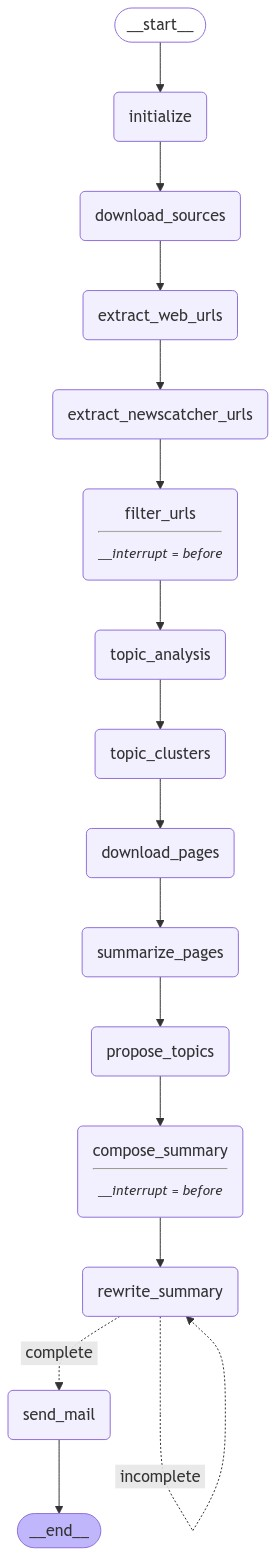

In [34]:
do_download = True
before_date = None
# before_date = '2024-11-07 16:00:00'
# use everything since this date even if already seen
# like if you want to rerun it for any reason after sqlite updated

# initial state
state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'cluster_topics': [],
    'topics_str': str,
    'n_edits': 0,
    'edit_complete': False,
#     'messages': None
    }
)
# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4().hex
config = {"configurable": {"thread_id": thread_id}}

log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent = Agent(state)
display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


# Run each step individually

In [35]:
# download and extract, human in the loop checks all sources downloaded OK
state = lg_agent.initialize(state)
state = lg_agent.download_sources(state)
state = lg_agent.extract_web_urls(state)
state = lg_agent.extract_newscatcher_urls(state)
# s/b 18 check all downloaded, if any got hit by a bot block then download manually
print(len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]))
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]


2024-11-09 17:50:59,704 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2024-11-09 17:50:59,704 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-11-09 17:50:59,704 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-11-09 17:50:59,704 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-11-09 17:50:59,704 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-11-09 17:50:59,705 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-11-09 17:50:59,705 - AInewsbot - INFO - 

2024-11-09 17:52:42,928 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

2024-11-09 17:52:42,930 - AInewsbot - INFO - get_files(FT Technology) - Saving FT Technology (11_09_2024 05_52_42 PM).html as utf-8
2024-11-09 17:52:42,931 - AInewsbot - INFO - Processing Hacker News 2
2024-11-09 17:52:42,932 - AInewsbot - INFO - get_files(Hacker News Page 2) - starting get_files https://news.ycombinator.com/?p=2
2024-11-09 17:52:49,656 - AInewsbot - INFO - get_files(Google News - Technology - Artificial intelligence)

2024-11-09 17:53:23,290 - AInewsbot - INFO - get_files(The Verge AI) - Saving The Verge AI (11_09_2024 05_53_23 PM).html as utf-8
2024-11-09 17:53:23,291 - AInewsbot - INFO - Processing WSJ Tech
2024-11-09 17:53:23,291 - AInewsbot - INFO - get_files(WSJ Technology) - starting get_files https://www.wsj.com/tech/ai
2024-11-09 17:53:26,515 - AInewsbot - INFO - get_files(VentureBeat AI) - Saving VentureBeat AI (11_09_2024 05_53_26 PM).html as UTF-8
2024-11-09 17:53:26,516 - AInewsbot - INFO - Processing WaPo Tech
2024-11-09 17:53:26,517 - AInewsbot - INFO - get_files(Washington Post Technology) - starting get_files https://www.washingtonpost.com/technology/innovations/
2024-11-09 17:53:29,136 - AInewsbot - INFO - get_files(Feedly AI) - Loading additional infinite scroll items
2024-11-09 17:53:32,381 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troub

2024-11-09 17:54:02,518 - AInewsbot - INFO - parse_file - found 169 raw links
2024-11-09 17:54:02,520 - AInewsbot - INFO - parse_file - found 68 filtered links
2024-11-09 17:54:02,520 - AInewsbot - INFO - 68 links found
2024-11-09 17:54:02,520 - AInewsbot - INFO - Hacker News -> htmldata/Hacker News Page 1 (11_09_2024 05_52_50 PM).html
2024-11-09 17:54:02,530 - AInewsbot - INFO - parse_file - found 258 raw links
2024-11-09 17:54:02,533 - AInewsbot - INFO - parse_file - found 23 filtered links
2024-11-09 17:54:02,533 - AInewsbot - INFO - 23 links found
2024-11-09 17:54:02,534 - AInewsbot - INFO - Hacker News 2 -> htmldata/Hacker News Page 2 (11_09_2024 05_52_53 PM).html
2024-11-09 17:54:02,544 - AInewsbot - INFO - parse_file - found 262 raw links
2024-11-09 17:54:02,547 - AInewsbot - INFO - parse_file - found 23 filtered links
2024-11-09 17:54:02,548 - AInewsbot - INFO - 23 links found
2024-11-09 17:54:02,548 - AInewsbot - INFO - HackerNoon -> htmldata/HackerNoon (11_09_2024 05_53_00 PM

18


,id
src,
Ars Technica,26
Bloomberg Tech,12
Business Insider,50
FT Tech,62
Feedly AI,29
Google News,68
Hacker News,21
Hacker News 2,23
HackerNoon,95


In [36]:
state = lg_agent.filter_urls(state)
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]


2024-11-09 17:54:03,964 - AInewsbot - INFO - Querying SQLite with where_clause: 
2024-11-09 17:54:04,613 - AInewsbot - INFO - URLs in orig_df: 994
2024-11-09 17:54:04,615 - AInewsbot - INFO - Existing URLs in DB: 178008
2024-11-09 17:54:04,642 - AInewsbot - INFO - New URLs in df filtered by URL: 190
2024-11-09 17:54:04,731 - AInewsbot - INFO - Existing src+title: 9
2024-11-09 17:54:04,731 - AInewsbot - INFO - New URLs in df filtered by src+title: 181
2024-11-09 17:54:04,742 - AInewsbot - INFO - Found 169 unique new headlines
2024-11-09 17:54:04,910 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-11-09 17:54:04,911 - AInewsbot - INFO - sent 50 items 
2024-11-09 17:54:04,912 - AInewsbot - INFO - sent 50 items 
2024-11-09 17:54:04,912 - AInewsbot - INFO - sent 50 items 
2024-11-09 17:54:04,913 - AInewsbot - INFO - sent 19 items 
2024-11-09 17:54:06,640 - AInewsbot - INFO - got dict with 19 items 
2024-11-09 17:54:08,180 - AInewsbot - INFO - got dict with 50 items 
2

,id
src,
Business Insider,1
Feedly AI,20
Google News,13
Hacker News,2
Newscatcher,15
Techmeme,1


In [37]:
for row in pd.DataFrame(state["AIdf"]).itertuples():
    display(Markdown(f"[{row.id}. {row.title} - {row.src}]({row.url})"))


[0. 3 Ways To Use ChatGPT Search To Make Money Online In 2024 - Google News](https://news.google.com/read/CBMioAFBVV95cUxORVpWOWRhT1ZuVk90QndDNDNWazRXVHNaTS00T2w4dlJFUTRjT2RfZF9ScGN1dWhCR28yeFNvcEtzTWdJTzdxZ1NBdVB3TV9WbGkzSVo4bDRaY01wd2dlZnVZQnh6V2F4bW9GU1JjakpHMGd1c0FSaG0xTmFlblp1ZEVtOUFOVF82WUloNjFUcFhwZHNBT0FfZVozLUI5dmxr)

[1. A Deep Dive into Small Language Models: Efficient Alternatives to Large Language Models for Real-Time Processing and Specialized Tasks - Feedly AI](https://www.marktechpost.com/2024/11/09/a-deep-dive-into-small-language-models-efficient-alternatives-to-large-language-models-for-real-time-processing-and-specialized-tasks/)

[2. AI-READI consortium launches groundbreaking diabetes data study - Newscatcher](https://www.msn.com/en-gb/health/other/ai-readi-consortium-launches-groundbreaking-diabetes-data-study/ar-AA1tKPLh)

[3. AI Tool Reveals Long COVID May Affect 23% of People - Feedly AI](https://neurosciencenews.com/ai-long-covid-28003/)

[4. AI companies get comfortable offering their technology to the military - Google News](https://news.google.com/read/CBMimAFBVV95cUxQTlVTenpaQkJxNUxUYURoLVZNV25KQjhYOHVySlg1OFAxTDVlNGw3cWtuQTdLVzF4cnV3Q2k3RDFxVkJnRDVxU1hPVEhxMzlQZHdjWTc2d3NwYWNZWUQzNEZLeXdMTUdodDNiOVF6YURNSDk5Mzl1VHlsdFBXNmphMFZ1bkdVdzl0ekZ0MWc5Q3VFOHJtQkhPSg)

[5. AI didn't sway the election, but it deepened the partisan divide - Newscatcher](https://www.washingtonpost.com/technology/2024/11/09/ai-deepfakes-us-election)

[6. AI didnt sway the election, but it deepened the partisan divide - Google News](https://news.google.com/read/CBMihAFBVV95cUxQVXc5RmhoN2NSZEFtSVVsd01KeDM3SzFyR2RNSnExTGdEaGhzdnZoaG0zTmE2RlNtMGRsb1RldlZMbzk3cHJleklQZjBoUElfR2FWRVFCZ2xmYzdUa3BxcG1JZTQteVAxYldqSGFUR3dfdVhfYmpCYlBoNEdDYllEZUF6OHA)

[7. AI groups rush to redesign model testing and create new benchmarks - Google News](https://news.google.com/read/CBMicEFVX3lxTE1oOW5JdFI0bWpJYkVMVS1fR21jLU83YXlQUVpGQzFEakJsYUZMVV80RFdyYXp4ZWZhLVZaSTJobVRNRVlhNTM5T2VtYzhwSkVLck9YSlczdGhXcnJTeFJzTTFzMDlyLTI3OVpvMW9WUjE)

[8. American AI company Vantiq launches project to develop smart cities in Ukraine - Feedly AI](https://kyivindependent.com/american-ai-company-vantiq-launches-project-to-develop-smart-cities-in-ukraine/)

[9. At last, it seems the law recognizes that AI synthesizes, not copies - Feedly AI](https://medium.com/enrique-dans/at-last-it-seems-the-law-recognizes-that-ai-synthesizes-not-copies-8489ba5616df)

[10. Can AI And Your Heart Rate Data Help You To Flourish? - Feedly AI](https://www.forbes.com/sites/johnwerner/2024/11/09/can-ai-and-your-heart-rate-data-help-you-to-flourish/)

[11. Can AI stop ships from killing thousands of whales each year? - Newscatcher](https://www.msn.com/en-us/travel/news/can-ai-stop-ships-from-killing-thousands-of-whales-each-year/ar-AA1tNAzZ)

[12. ChatGPT denied 250,000 requests to generate deepfake images of candidates in the month before the election - Business Insider](https://www.businessinsider.com/chatgpt-openai-denied-requests-generate-images-candidates-election-trump-harris-2024-11)

[13. ChatGPT rejected more than 250,000 image generations of presidential candidates prior to Election Day - Feedly AI](https://www.nbcnews.com/tech/chatgpt-rejected-image-generations-presidential-candidates-rcna179469)

[14. Chegg Is On Its Last Legs After ChatGPT Sent Its Stock Down 99% - Feedly AI](https://gizmodo.com/chegg-is-on-its-last-legs-after-chatgpt-sent-its-stock-down-99-2000522585)

[15. Claude AI to process secret government data through new Palantir deal - Google News](https://news.google.com/read/CBMirAFBVV95cUxNWmZGV284amdOOVJWUl9nWFFYZTZCZzA3Z3c3eGJGUW04aUh2QndhRWpPcmdrY3d3MlVWLWV0WDNFVDdQRlo1U1dFOUp3M0hvZXVoN3dpVWRVcDVTQWY1Ym1rMHdreE9ZdW1ZOFZWc3BwOVlQZFEtZFplTm41SHlKazNKdlMzNFc1WXMyTTltOEVqOHMxZlRwUlFtdXE1MDZRTmxTb0E4WlFNZV9F)

[16. Cloud Computing Market to Grow by USD 404.7 Billion from 2024-2028, as Cost-Cutting Drives Adoption with AI Driving Market Transformation - Newscatcher](https://finance.yahoo.com/news/cloud-computing-market-grow-usd-222000832.html)

[17. Federal court sides with OpenAI in AI copyright lawsuit - Newscatcher](https://siliconangle.com/2024/11/08/federal-court-sides-openai-ai-copyright-lawsuit)

[18. FrontierMath: A benchmark for evaluating advanced mathematical reasoning in AI - Hacker News](https://epochai.org/frontiermath/the-benchmark)

[19. Gemini AI Now Accessible Through the OpenAI Library for Streamlined Use - Feedly AI](https://www.marktechpost.com/2024/11/09/gemini-ai-now-accessible-through-the-openai-library-for-streamlined-use/)

[20. Goodbye Google? How to use ChatGPTs new web search. - Google News](https://news.google.com/read/CBMiYkFVX3lxTE04bzJkYXhEU3RfRmhvYzZHUDEwc0hCd0djUlpRV19OU1c1cVB0LXRFRmhIUnJWby1pUkYxdGV6RGxWc3o0UlRQXzJOMl9zc29OOGFMNU1rV0xlVlBMOGhkVlRB)

[21. Google says Enhanced protection feature in Chrome now uses AI - Feedly AI](https://www.bleepingcomputer.com/news/google/google-says-enhanced-protection-feature-in-chrome-now-uses-ai/)

[22. Hands on with AI features in Windows 11 Paint and Notepad - Feedly AI](https://www.bleepingcomputer.com/news/microsoft/hands-on-with-ai-features-in-windows-11-paint-and-notepad/)

[23. Headshot Photographers: AI Is About To Eat Your Lunch - Feedly AI](https://fstoppers.com/artificial-intelligence/headshot-photographers-ai-about-eat-your-lunch-684878)

[24. Here's your first look at Google Meet's AI backgrounds on Android - Feedly AI](https://www.androidpolice.com/google-meet-ai-backgrounds-android-demo/)

[25. Here are 3 critical LLM compression strategies to supercharge AI performance - Google News](https://news.google.com/read/CBMipwFBVV95cUxPZmZUQ0V0aUllWHpIY3RndEM4cWhGOGdKSmo4eVBkTTE3aDRETmlfeTBwenhId1RuNDVvY2F1VDVqWnBmcWlvLTNzcFRSZlN6ZW5PZVVVOGZUdl9qNFJiM2J6djRUMDJjRTJWUG5vQWNzUzYxNlVja0NwUWFvNW5ESnlwNU5MaVlQcDBHT214R2NMTE5wSWtzeFFmRkE2OWdiVEp2ejVnNA)

[26. How Agentic AI will revolutionize business operations  are you ready? - Feedly AI](https://www.techradar.com/pro/how-agentic-ai-will-revolutionize-business-operations-are-you-ready)

[27. I Compared ChatGPT Search and Google, and Google Should Be Worried - Google News](https://news.google.com/read/CBMikwFBVV95cUxNWWxzQUgweHY3SWVYM1hOLUdrQXJuMmJVbFJHWmtDenJrRWVNRUtKRDZvdWh4U3JHNjRWTGJBRDBVZzBULUI2UzNVdGpXTGJBVUR1c2VnYUFnMU9xMGZIVU1lNmdNYXhzZGh3Z3JvQUxId2tyTTZYUnd1TW9UU2xxRkRsUl9QRV8xNVc5TkVaZWN4dDA)

[28. I found these 5 tips helped me get the most out of ChatGPT Search - Google News](https://news.google.com/read/CBMiiAFBVV95cUxPM01Qa2ZGUHllTjdDNWkxRVdvYTFTYm5jNGdhRFhCU1B6YW9Kc1lyeHdBZ0JUQkdOVG5JbkdzTmJQNzRJS0hPTlM5c0JCaVZFRE51bGtvTnZlV01WVG9hZTU3RkFzTjJ0VWdXUEFmSXZIalhLVHpnT2lMbGRDNUZNc2o3eXAyR1Fz)

[29. ML analysis tracks the evolution of 16th-century European astronomical thought - Hacker News](https://phys.org/news/2024-10-machine-analysis-tracks-evolution-16th.html)

[30. Microsoft added AI to software it has barely touched since 1985. The results are astonishing - Feedly AI](https://edition.cnn.com/2024/11/08/business/microsoft-paint-artificial-intelligence/index.html)

[31. New fanless cooling technology enhances energy efficiency for AI workloads by achieving a 90% reduction in cooling power consumption - Feedly AI](https://www.techradar.com/pro/new-fanless-cooling-technology-enhances-energy-efficiency-for-ai-workloads-by-achieving-a-90-percent-reduction-in-cooling-power-consumption)

[32. Ofcom warns tech firms after chatbots imitate Brianna Ghey and Molly Russell - Newscatcher](https://ca.finance.yahoo.com/news/ofcom-warns-tech-firms-chatbots-060040536.html)

[33. Om Malik  With AI, the Future of Augmented Reality Is in Your Ears - Feedly AI](https://crazystupidtech.com/archive/with-ai-the-future-of-augmented-reality-is-in/)

[34. OpenAI's CEO Sam Altman Predicts AGI Could Appear Within Five Years, With Far Less Impact On Society Than Most Expect - Newscatcher](https://wccftech.com/openai-ceo-sam-altman-predicts-agi-could-appear-within-five-years)

[35. OpenAI Has, For Now, Escaped Copyright Lawsuit Filed Against It Regarding Its Use Of News Articles Without Consent To Train ChatGPT - Newscatcher](https://wccftech.com/openai-escaped-copyright-laws)

[36. OpenAI backs robots, Amazon and Palantir's defense deal, Saudi Arabia's $100 billion bet: This week's AI launches - Newscatcher](https://www.yahoo.com/tech/openai-backs-robots-amazon-palantirs-100000753.html)

[37. Running Large Language Models Privately | by Robert Corwin | Oct, 2024 - Google News](https://news.google.com/read/CBMixgFBVV95cUxPeGE2VFlFWkltUXIwV3pPM2pxTHM1STQyME1EWjVuRlp2aDR4djU3QVloVU5zSDZmd0lQSUdpOHdIeXZMQjM5UHp3Z3NwMjgyUkhheGNLbzFQb3F4LXFhUUNLeHJyaThVSEFwaDZJcnRRVTNNakhXQ2FrdkVVc0ZxS0FEZmZMMURqUjNxQW9jY3kyem1fRDJfMVdKbThBRTBvUEpoWVp0Um5CX25qU0RGNU56UE9Va21nbHJfYWZJeVA2M0tOMVE)

[38. Samsung plans record-breaking 400-layer NAND chip that could be key to breaking 200TB barrier for ultra large capacity AI hyperscaler SSDs - Feedly AI](https://www.techradar.com/pro/samsung-plans-record-breaking-400-layer-nand-chip-that-could-be-key-to-breaking-200tb-barrier-for-ultra-large-capacity-ai-hyperscaler-ssds)

[39. Scientists Are Testing AI That Could Detect Pain in Goats Just By Their Facial Expressions - Feedly AI](https://gizmodo.com/scientists-are-testing-ai-that-could-detect-pain-in-goats-just-by-their-facial-expressions-2000522501)

[40. Small Language Models Gaining Popularity While LLMs Still Go Strong - Google News](https://news.google.com/read/CBMihAJBVV95cUxNYlp0RnQ2U25qTmxpR2JwOHBLWEd1dFc2cWFISGk3Zm5xMVdybm9MNzBFVzFQajZZQVBuRDI3Nzk5NDdpc3llc2U5bmY5Q2RtYmM1ZkpIM0hNemJDMFpGTm9OWl9VOFF1WjFELUlKV2prVnFZTFE0ZkF5WUItTGduZHFoNi1VSXVXSzNyVkkyeUtfOVVWQ1FwTThqZEg2cTU0TFVCYzlTY0c3ZXdJbWxJTWQ3NU1BamVUSEJsLWJWa1JPSTRQVDB1ekc3QmxTLWdQaWhzZG1Nbmd4STRwYUx4YkhnY3RCeW50eExKX3JHVVNJY3RPY3l6a1kteC1LZGl5Mm4xTg)

[41. Sources: the jump in quality from GPT-4 to Orion is far smaller than the jump from GPT-3 to GPT-4; Orion may not outperform predecessors in tasks like coding (The Information) - Feedly AI](https://www.theinformation.com/articles/openai-shifts-strategy-as-rate-of-gpt-ai-improvements-slows)

[42. TSMC may stop producing AI chips for Chinese companies - Newscatcher](https://www.androidheadlines.com/2024/11/tsmc-may-stop-producing-ai-chips-for-chinese-companies.html)

[43. TSMC to Suspend AI Chips Production for China From November 11: Report - Newscatcher](https://www.gadgets360.com/ai/news/tsmc-suspend-advanced-ai-chip-production-china-report-6981141)

[44. The Beatles final song, restored using AI, is up for a Grammy - Google News](https://news.google.com/read/CBMimgFBVV95cUxOX2ZnTHBsNHgxbmtMc1EtNDY3ZFRhN2taWktCRmkwYzdCcFFtbjl3Q1htVS1vUkJBS3piaVgxRmhhMUg1MUhjTW0ta2pNb19TMWx5cV9vYk81b0Q2MEtwRkVld25pTWlTUnJHbTdmQUFRNUFCM29JeWd5LVVyQjJjRXA2VGRqaldJRHZoMjZWVklEVFE5S0owdHdn)

[45. The Taiwan Semiconductor Industry Association says Taiwan's semiconductor production is on track to increase 22% YoY to a record $165B in 2024 on AI demand - Techmeme](https://t.co/LHrQIaHRfq)

[46. UnifyApps reels in $20M for its AI-powered application platform - Newscatcher](https://siliconangle.com/2024/11/08/unifyapps-reels-20m-ai-powered-application-platform)

[47. Vancouver high school students create intelligent garbage cans to help sort waste - Newscatcher](https://ca.news.yahoo.com/vancouver-high-school-students-create-130000179.html)

[48. Warren Buffett's AI Bets: 24.1% of Berkshire Hathaway's $287 Billion Stock Portfolio Is Invested in These 2 Artificial Intelligence Stocks - Newscatcher](https://finance.yahoo.com/news/warren-buffetts-ai-bets-24-111800171.html)

[49. When machine learning tells the wrong story - Feedly AI](https://jackcook.com/2024/11/09/bigger-fish.html)

[50. Why is AI unable to predict disasters like Spains flash flooding in time? - Google News](https://news.google.com/read/CBMixAFBVV95cUxNbm5xQkxHTTM3Q2YwN3ctelpOM0I5Z0tWWE1rV1JTM3p1a29zNl9URkFkZTRDUG1ocjZzMzhqUzBLaTlUQUZQMUViYnA1dEc0QktFNkVQREROSkJtX1BpNWhvbjhFOFBnbWI2MmZWMG1Hbk5zWFF1NnlycnBHWUNXUnJTeGt0eThibm4tN0tELTc5U1RYelZaRHp1czdHR1FFNUhhcXE0OXdxY1o3QVRMZ1J6aThhRF9TUlhVRDZtT1UxX2s2)

[51. eBay Inc. (EBAY)'s Secret to Dominating Internet Retail: AI Innovations and Revenue Growth - Newscatcher](https://finance.yahoo.com/news/ebay-inc-ebay-secret-dominating-195907555.html)

In [38]:
# do topic analysis, identify good topics
state = lg_agent.topic_analysis(state)
state = lg_agent.topic_clusters(state)

# download and summarize pages
state = lg_agent.download_pages(state)
state = lg_agent.summarize_pages(state)
# free-form extract topics from summarize, combine with clusters, propose clean topics
state = lg_agent.propose_topics(state)
print(state["topics_str"])
# compose using o1-preview and rewrite summary 3 times
state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete':
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)

2024-11-09 17:54:08,714 - AInewsbot - INFO - start free-form topic extraction
2024-11-09 17:54:08,715 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-09 17:54:08,715 - AInewsbot - INFO - sent 50 items 
2024-11-09 17:54:08,715 - AInewsbot - INFO - sent 2 items 
2024-11-09 17:54:10,110 - AInewsbot - INFO - got dict with 2 items 
2024-11-09 17:54:16,066 - AInewsbot - INFO - got dict with 50 items 
2024-11-09 17:54:16,069 - AInewsbot - INFO - Processed 52 responses.
2024-11-09 17:54:16,072 - AInewsbot - INFO - 52 free-form topics extracted
2024-11-09 17:54:16,074 - AInewsbot - INFO - ['chatgpt', 'search', '2024', 'small language models', 'large language models', 'research', 'health', 'election', 'partisan divide', 'politics', 'intellectual property', 'image generation', 'business', 'palantir', 'openai', 'copyright lawsuit', 'legal', 'google', 'performance', 'innovation', 'machine learning', 'tsmc', 'ai chips', 'china']
2024-11-09 17:54:16,076 - AInewsbot - INFO - 

2024-11-09 17:55:04,119 - AInewsbot - INFO - got dict with 2 items 
2024-11-09 17:55:06,441 - AInewsbot - INFO - got dict with 50 items 
2024-11-09 17:55:06,445 - AInewsbot - INFO - Processed 52 responses.
2024-11-09 17:55:06,447 - AInewsbot - INFO - Computer Vision, topic 16 of 100
2024-11-09 17:55:06,449 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-09 17:55:06,451 - AInewsbot - INFO - sent 50 items 
2024-11-09 17:55:06,453 - AInewsbot - INFO - sent 2 items 
2024-11-09 17:55:07,402 - AInewsbot - INFO - got dict with 2 items 
2024-11-09 17:55:09,946 - AInewsbot - INFO - got dict with 50 items 
2024-11-09 17:55:09,950 - AInewsbot - INFO - Processed 52 responses.
2024-11-09 17:55:09,951 - AInewsbot - INFO - Consciousness, topic 17 of 100
2024-11-09 17:55:09,952 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-09 17:55:09,954 - AInewsbot - INFO - sent 50 items 
2024-11-09 17:55:09,955 - AInewsbot - INFO - sent 2 items 
2024-11-09 17:55

2024-11-09 17:56:09,731 - AInewsbot - INFO - sent 50 items 
2024-11-09 17:56:09,732 - AInewsbot - INFO - sent 2 items 
2024-11-09 17:56:10,238 - AInewsbot - INFO - got dict with 2 items 
2024-11-09 17:56:12,875 - AInewsbot - INFO - got dict with 50 items 
2024-11-09 17:56:12,882 - AInewsbot - INFO - Processed 52 responses.
2024-11-09 17:56:12,883 - AInewsbot - INFO - Finance, topic 33 of 100
2024-11-09 17:56:12,884 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-09 17:56:12,885 - AInewsbot - INFO - sent 50 items 
2024-11-09 17:56:12,886 - AInewsbot - INFO - sent 2 items 
2024-11-09 17:56:14,920 - AInewsbot - INFO - got dict with 2 items 
2024-11-09 17:56:16,300 - AInewsbot - INFO - got dict with 50 items 
2024-11-09 17:56:16,303 - AInewsbot - INFO - Processed 52 responses.
2024-11-09 17:56:16,304 - AInewsbot - INFO - Fintech, topic 34 of 100
2024-11-09 17:56:16,305 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-09 17:56:16,306 - AIne

2024-11-09 17:57:04,724 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-09 17:57:04,728 - AInewsbot - INFO - sent 50 items 
2024-11-09 17:57:04,734 - AInewsbot - INFO - sent 2 items 
2024-11-09 17:57:05,329 - AInewsbot - INFO - got dict with 2 items 
2024-11-09 17:57:07,875 - AInewsbot - INFO - got dict with 50 items 
2024-11-09 17:57:07,878 - AInewsbot - INFO - Processed 52 responses.
2024-11-09 17:57:07,878 - AInewsbot - INFO - Internet of Things, topic 50 of 100
2024-11-09 17:57:07,879 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-09 17:57:07,880 - AInewsbot - INFO - sent 50 items 
2024-11-09 17:57:07,882 - AInewsbot - INFO - sent 2 items 
2024-11-09 17:57:08,478 - AInewsbot - INFO - got dict with 2 items 
2024-11-09 17:57:11,278 - AInewsbot - INFO - got dict with 50 items 
2024-11-09 17:57:11,281 - AInewsbot - INFO - Processed 52 responses.
2024-11-09 17:57:11,282 - AInewsbot - INFO - Japan, topic 51 of 100
2024-11-09 17:57:11,2

2024-11-09 17:58:03,431 - AInewsbot - INFO - Processed 52 responses.
2024-11-09 17:58:03,432 - AInewsbot - INFO - Policy and regulation, topic 66 of 100
2024-11-09 17:58:03,433 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-09 17:58:03,435 - AInewsbot - INFO - sent 50 items 
2024-11-09 17:58:03,437 - AInewsbot - INFO - sent 2 items 
2024-11-09 17:58:04,904 - AInewsbot - INFO - got dict with 2 items 
2024-11-09 17:58:07,385 - AInewsbot - INFO - got dict with 50 items 
2024-11-09 17:58:07,387 - AInewsbot - INFO - Processed 52 responses.
2024-11-09 17:58:07,388 - AInewsbot - INFO - Politics, topic 67 of 100
2024-11-09 17:58:07,390 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-09 17:58:07,391 - AInewsbot - INFO - sent 50 items 
2024-11-09 17:58:07,393 - AInewsbot - INFO - sent 2 items 
2024-11-09 17:58:07,984 - AInewsbot - INFO - got dict with 2 items 
2024-11-09 17:58:11,462 - AInewsbot - INFO - got dict with 50 items 
2024-11-09 17:5

2024-11-09 17:59:00,324 - AInewsbot - INFO - got dict with 2 items 
2024-11-09 17:59:02,768 - AInewsbot - INFO - got dict with 50 items 
2024-11-09 17:59:02,771 - AInewsbot - INFO - Processed 52 responses.
2024-11-09 17:59:02,772 - AInewsbot - INFO - Smart grid, topic 83 of 100
2024-11-09 17:59:02,772 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-09 17:59:02,773 - AInewsbot - INFO - sent 50 items 
2024-11-09 17:59:02,774 - AInewsbot - INFO - sent 2 items 
2024-11-09 17:59:03,266 - AInewsbot - INFO - got dict with 2 items 
2024-11-09 17:59:05,775 - AInewsbot - INFO - got dict with 50 items 
2024-11-09 17:59:05,777 - AInewsbot - INFO - Processed 52 responses.
2024-11-09 17:59:05,777 - AInewsbot - INFO - Society & Culture, topic 84 of 100
2024-11-09 17:59:05,778 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-09 17:59:05,780 - AInewsbot - INFO - sent 50 items 
2024-11-09 17:59:05,781 - AInewsbot - INFO - sent 2 items 
2024-11-09 17:59:

2024-11-09 17:59:55,754 - AInewsbot - INFO - sent 50 items 
2024-11-09 17:59:55,755 - AInewsbot - INFO - sent 2 items 
2024-11-09 17:59:56,184 - AInewsbot - INFO - got dict with 2 items 
2024-11-09 17:59:59,513 - AInewsbot - INFO - got dict with 50 items 
2024-11-09 17:59:59,516 - AInewsbot - INFO - Processed 52 responses.
2024-11-09 17:59:59,516 - AInewsbot - INFO - Virtual Assistants, topic 100 of 100
2024-11-09 17:59:59,517 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-09 17:59:59,518 - AInewsbot - INFO - sent 50 items 
2024-11-09 17:59:59,520 - AInewsbot - INFO - sent 2 items 
2024-11-09 18:00:01,046 - AInewsbot - INFO - got dict with 2 items 
2024-11-09 18:00:03,591 - AInewsbot - INFO - got dict with 50 items 
2024-11-09 18:00:03,593 - AInewsbot - INFO - Processed 52 responses.
2024-11-09 18:00:03,594 - AInewsbot - INFO - end canonical topic classification
2024-11-09 18:00:03,607 - AInewsbot - INFO - Fetching embeddings for 52 headlines
2024-11-09 18:00

,id,title_topic_str
0,0,"I found these 5 tips helped me get the most out of ChatGPT Search (Topics: Chatbots, Chatgpt, Code Assistants, Gen AI, Language Models, Opinion, Optimization, Review, Search, Tips, Virtual Assistants)"
1,1,"3 Ways To Use ChatGPT Search To Make Money Online In 2024 (Topics: 2024, Chatbots, Chatgpt, Economics, Finance, Gen AI, Language Models, Money, Online, Search, Virtual Assistants)"
2,2,"Chegg Is On Its Last Legs After ChatGPT Sent Its Stock Down 99% (Topics: Books & Publishing, Business, Chatbots, Chatgpt, Chegg, Code Assistants, Economics, Education, Finance, Gen AI, Job Automation, Jobs & Careerslabor Market, Language Models, Products, Stock Market, Stocks, Virtual Assistants)"


2024-11-09 18:00:07,808 - AInewsbot - INFO - {'topic_title': 'ChatGPT and Online Opportunities'}
2024-11-09 18:00:07,808 - AInewsbot - INFO - I dub this cluster: ChatGPT and Online Opportunities


,id,title_topic_str
3,3,"Running Large Language Models Privately | by Robert Corwin | Oct, 2024 (Topics: Authors & Writing, Cognitive Science, Gen AI, Language Models, Large Language Models, Opinion, Privacy, Privacy & Surveillance, Research, Speech Recognition & Synthesis)"
4,4,"Here are 3 critical LLM compression strategies to supercharge AI performance (Topics: Artificial General Intelligence, Cognitive Science, Compression Strategies, Gen AI, Language Models, Llm, Performance, Science, Speech Recognition & Synthesis)"
5,5,"A Deep Dive into Small Language Models: Efficient Alternatives to Large Language Models for Real-Time Processing and Specialized Tasks (Topics: Cognitive Science, Efficiency, Gen AI, Language Models, Large Language Models, Real-Time Processing, Science, Small Language Models, Speech Recognition & Synthesis)"
6,6,"Small Language Models Gaining Popularity While LLMs Still Go Strong (Topics: Cognitive Science, Gen AI, Language Models, Large Language Models, Popularity, Science, Small Language Models, Speech Recognition & Synthesis)"


2024-11-09 18:00:08,157 - AInewsbot - INFO - {'topic_title': 'Language Models and AI Performance'}
2024-11-09 18:00:08,158 - AInewsbot - INFO - I dub this cluster: Language Models and AI Performance


,id,title_topic_str
7,7,"TSMC to Suspend AI Chips Production for China From November 11: Report (Topics: AI Chips, China, Economics, Gen AI, Governance, Hardware, Manufacturing, Policy And Regulation, Politics, Production, Products, Semiconductor Chips, Taiwan, Tsmc)"
8,8,"TSMC may stop producing AI chips for Chinese companies (Topics: AI Chips, China, Economics, Gen AI, Governance, Hardware, Manufacturing, Policy And Regulation, Politics, Products, Semiconductor Chips, Semiconductors, Taiwan, Tsmc)"
9,9,"The Taiwan Semiconductor Industry Association says Taiwan's semiconductor production is on track to increase 22% YoY to a record $165B in 2024 on AI demand (Topics: 2024, Economics, Economy, Finance, Gen AI, Hardware, Job Automation, Jobs & Careerslabor Market, Manufacturing, Products, Semiconductor Chips, Semiconductor Production, Taiwan, Taiwan Semiconductor Industry Association)"


2024-11-09 18:00:08,546 - AInewsbot - INFO - {'topic_title': 'Taiwan Semiconductor Industry and AI Chips'}
2024-11-09 18:00:08,547 - AInewsbot - INFO - I dub this cluster: Taiwan Semiconductor Industry and AI Chips
2024-11-09 18:00:08,569 - AInewsbot - INFO - Queuing URLs for scraping
2024-11-09 18:00:08,571 - AInewsbot - INFO - fetching 52 pages using 4 browsers
2024-11-09 18:00:08,572 - AInewsbot - INFO - get_driver - 32331 Initializing webdriver
2024-11-09 18:00:08,572 - AInewsbot - INFO - get_driver - 32331 Initializing webdriver
2024-11-09 18:00:08,573 - AInewsbot - INFO - get_driver - 32331 Initializing webdriver
2024-11-09 18:00:08,573 - AInewsbot - INFO - get_driver - 32331 Initializing webdriver


['ChatGPT and Online Opportunities', 'Language Models and AI Performance', 'Taiwan Semiconductor Industry and AI Chips']


2024-11-09 18:00:28,129 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-09 18:00:28,130 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-09 18:00:28,130 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-09 18:00:28,130 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-09 18:00:28,130 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-11-09 18:00:28,130 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-11-09 18:00:28,131 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-11-09 18:00:28,131 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-11-09 18:01:36,003 - AInewsbot - INFO - get_driver - Initialized webdriver
2024-11-09 18:01:36,046 - AInewsbot - INFO - Processing page 0: https://news.google.com/read/CBMiiAFBVV95cUxPM01Qa2ZGUHllTjdDNWkxRVdvYTFTYm5jNGdhRFhCU1B6YW9Kc1lyeHdBZ0JUQkdOVG5JbkdzTmJQNzRJS0hPTlM5c0JCaVZFRE51bGtvTnZ

2024-11-09 18:01:57,673 - AInewsbot - INFO - get_url(Here are 3 critical LLM compression strategies to supercharge AI performance) - Saving Here_are_3_critical_LLM_compression_strategies_to_supercharge_AI_performance.html as utf-8
2024-11-09 18:01:57,674 - AInewsbot - INFO - Processing page 8: https://www.androidheadlines.com/2024/11/tsmc-may-stop-producing-ai-chips-for-chinese-companies.html
2024-11-09 18:01:57,674 - AInewsbot - INFO - get_url(https://www.androidheadlines.com/2024/11/tsmc-may-stop-producing-ai-chips-for-chinese-companies.html) - starting get_url https://www.androidheadlines.com/2024/11/tsmc-may-stop-producing-ai-chips-for-chinese-companies.html
2024-11-09 18:02:04,676 - AInewsbot - INFO - get_url(A Deep Dive into Small Language Models: Efficient Alternatives to Large Language Models for Real-Time Processing and Specialized Tasks) - Saving A_Deep_Dive_into_Small_Language_Models__Efficient_Alternatives_to_Large_Language_Models_for_Real-Time_Processing_and_Specialized_Ta

2024-11-09 18:02:38,798 - AInewsbot - INFO - Processing page 20: https://www.bleepingcomputer.com/news/microsoft/hands-on-with-ai-features-in-windows-11-paint-and-notepad/
2024-11-09 18:02:38,798 - AInewsbot - INFO - get_url(https://www.bleepingcomputer.com/news/microsoft/hands-on-with-ai-features-in-windows-11-paint-and-notepad/) - starting get_url https://www.bleepingcomputer.com/news/microsoft/hands-on-with-ai-features-in-windows-11-paint-and-notepad/
2024-11-09 18:02:41,383 - AInewsbot - INFO - get_url(Can AI stop ships from killing thousands of whales each year?) - Saving Can_AI_stop_ships_from_killing_thousands_of_whales_each_year_.html as utf-8
2024-11-09 18:02:41,384 - AInewsbot - INFO - Processing page 21: https://news.google.com/read/CBMimgFBVV95cUxOX2ZnTHBsNHgxbmtMc1EtNDY3ZFRhN2taWktCRmkwYzdCcFFtbjl3Q1htVS1vUkJBS3piaVgxRmhhMUg1MUhjTW0ta2pNb19TMWx5cV9vYk81b0Q2MEtwRkVld25pTWlTUnJHbTdmQUFRNUFCM29JeWd5LVVyQjJjRXA2VGRqaldJRHZoMjZWVklEVFE5S0owdHdn
2024-11-09 18:02:41,384 - AInewsb

2024-11-09 18:03:25,724 - AInewsbot - INFO - get_url(UnifyApps reels in $20M for its AI-powered application platform) - Saving UnifyApps_reels_in__20M_for_its_AI-powered_application_platform.html as utf-8
2024-11-09 18:03:25,725 - AInewsbot - INFO - Processing page 32: https://news.google.com/read/CBMihAFBVV95cUxQVXc5RmhoN2NSZEFtSVVsd01KeDM3SzFyR2RNSnExTGdEaGhzdnZoaG0zTmE2RlNtMGRsb1RldlZMbzk3cHJleklQZjBoUElfR2FWRVFCZ2xmYzdUa3BxcG1JZTQteVAxYldqSGFUR3dfdVhfYmpCYlBoNEdDYllEZUF6OHA
2024-11-09 18:03:25,725 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMihAFBVV95cUxQVXc5RmhoN2NSZEFtSVVsd01KeDM3SzFyR2RNSnExTGdEaGhzdnZoaG0zTmE2RlNtMGRsb1RldlZMbzk3cHJleklQZjBoUElfR2FWRVFCZ2xmYzdUa3BxcG1JZTQteVAxYldqSGFUR3dfdVhfYmpCYlBoNEdDYllEZUF6OHA) - starting get_url https://news.google.com/read/CBMihAFBVV95cUxQVXc5RmhoN2NSZEFtSVVsd01KeDM3SzFyR2RNSnExTGdEaGhzdnZoaG0zTmE2RlNtMGRsb1RldlZMbzk3cHJleklQZjBoUElfR2FWRVFCZ2xmYzdUa3BxcG1JZTQteVAxYldqSGFUR3dfdVhfYmpCYlBoNEdDYllEZUF6OHA
2024-11-09 18:03:2

2024-11-09 18:03:58,465 - AInewsbot - INFO - get_url(AI companies get comfortable offering their technology to the military) - Saving AI_companies_get_comfortable_offering_their_technology_to_the_military.html as utf-8
2024-11-09 18:03:58,475 - AInewsbot - INFO - Processing page 43: https://ca.news.yahoo.com/vancouver-high-school-students-create-130000179.html
2024-11-09 18:03:58,480 - AInewsbot - INFO - get_url(https://ca.news.yahoo.com/vancouver-high-school-students-create-130000179.html) - starting get_url https://ca.news.yahoo.com/vancouver-high-school-students-create-130000179.html
2024-11-09 18:03:59,593 - AInewsbot - INFO - get_url(Google says Enhanced protection feature in Chrome now uses AI) - Saving Google_says_Enhanced_protection_feature_in_Chrome_now_uses_AI.html as utf-8
2024-11-09 18:03:59,593 - AInewsbot - INFO - Processing page 44: https://gizmodo.com/scientists-are-testing-ai-that-could-detect-pain-in-goats-just-by-their-facial-expressions-2000522501
2024-11-09 18:03:5

2024-11-09 18:04:29,050 - AInewsbot - INFO - Quit webdriver
2024-11-09 18:04:29,125 - AInewsbot - INFO - 13 pages saved
2024-11-09 18:04:31,776 - AInewsbot - INFO - 14 pages saved
2024-11-09 18:04:33,064 - AInewsbot - INFO - get_url(When machine learning tells the wrong story) - Saving When_machine_learning_tells_the_wrong_story.html as utf-8
2024-11-09 18:04:33,077 - AInewsbot - INFO - Quit webdriver
2024-11-09 18:04:34,953 - AInewsbot - INFO - 12 pages saved
2024-11-09 18:04:37,921 - AInewsbot - INFO - 13 pages saved
2024-11-09 18:04:37,923 - AInewsbot - INFO - returned 52
2024-11-09 18:04:37,969 - AInewsbot - INFO - Starting summarize
2024-11-09 18:04:38,015 - AInewsbot - INFO - fetch_all_summaries - Page title: I found these 5 tips helped me get the most out of ChatGPT Search | Tom's Guide
Social card title: I found these 5 tips helped me get the most out of ChatGPT Search
Social card description: Have a chat with your search engine

2024-11-09 18:04:38,161 - AInewsbot - INFO - fet

2024-11-09 18:04:39,255 - AInewsbot - INFO - fetch_all_summaries - Page title: OpenAI Has, For Now, Escaped Copyright Lawsuit Filed Against It Regarding Its Use Of News Articles Without Consent To Train ChatGPT
Social card title: OpenAI Has, For Now, Escaped Copyright Lawsuit Filed Against It Regarding Its Use Of News Articles Without Consent To Train ChatGPT
Social card description: A Reuters report revealed that OpenAI has been able to escape a copyright lawsuit against it for training its AI models.

2024-11-09 18:04:39,266 - AInewsbot - INFO - fetch_all_summaries - Page title: Can AI stop ships from killing thousands of whales each year?
Social card title: Can AI stop ships from killing thousands of whales each year?
Social card description: With an estimated 20,000 whales dying from ship strikes each year, the Woods Hole Oceanographic Institution in Falmouth, Mass. is working to use artificial intelligence and thermal-imaging cameras to diminish these unnecessary deaths.

2024-11-

2024-11-09 18:04:40,217 - AInewsbot - INFO - fetch_all_summaries - Page title: Cloud Computing Market to Grow by USD 404.7 Billion from 2024-2028, as Cost-Cutting Drives Adoption with AI Driving Market Transformation - Technavio
Social card title: Cloud Computing Market to Grow by USD 404.7 Billion from 2024-2028, as Cost-Cutting Drives Adoption with AI Driving Market Transformation - Technavio
Social card description: Report with the AI impact on market trends - The global cloud computing market size is estimated to grow by USD 404.7 billion from 2024-2028, according to Technavio. The market is estimated to grow at a CAGR of 15.19% during the forecast period. Increased inclination toward cloud computing for cost-cutting is driving market growth, with a trend towards increased inclination for private cloud for enhanced data security. However, system integration issues poses a challenge. Key market players incl

2024-11-09 18:04:40,325 - AInewsbot - INFO - fetch_all_summaries - Page tit

2024-11-09 18:04:45,497 - AInewsbot - INFO - Received 52 summaries


[1. I found these 5 tips helped me get the most out of ChatGPT Search - Google News](https://news.google.com/read/CBMiiAFBVV95cUxPM01Qa2ZGUHllTjdDNWkxRVdvYTFTYm5jNGdhRFhCU1B6YW9Kc1lyeHdBZ0JUQkdOVG5JbkdzTmJQNzRJS0hPTlM5c0JCaVZFRE51bGtvTnZlV01WVG9hZTU3RkFzTjJ0VWdXUEFmSXZIalhLVHpnT2lMbGRDNUZNc2o3eXAyR1Fz)  

 ChatGPT and Online Opportunities, Chatbots, Chatgpt, Code Assistants, Gen AI, Language Models, Opinion, Optimization, Review, Search, Tips, Virtual Assistants  

- ChatGPT Search, recently integrated into the platform, offers a conversational approach to searching, with features distinct from traditional search engines like Google.
- Users are encouraged to utilize natural language queries for better results, engage in follow-up questions for clarity, and explore citations and multimedia content for enhanced information retrieval.
- The search engine supports site-specific and time-range queries, allowing users to refine their search without complex commands. 



[2. 3 Ways To Use ChatGPT Search To Make Money Online In 2024 - Google News](https://news.google.com/read/CBMioAFBVV95cUxORVpWOWRhT1ZuVk90QndDNDNWazRXVHNaTS00T2w4dlJFUTRjT2RfZF9ScGN1dWhCR28yeFNvcEtzTWdJTzdxZ1NBdVB3TV9WbGkzSVo4bDRaY01wd2dlZnVZQnh6V2F4bW9GU1JjakpHMGd1c0FSaG0xTmFlblp1ZEVtOUFOVF82WUloNjFUcFhwZHNBT0FfZVozLUI5dmxr)  

 ChatGPT and Online Opportunities, 2024, Chatbots, Chatgpt, Economics, Finance, Gen AI, Language Models, Money, Online, Search, Virtual Assistants  

- ChatGPT Search, launched on November 1, 2024, allows users to access real-time web search capabilities, enhancing the AI's usefulness for tasks like content creation and market research.
- The tool can aid in freelance writing by providing up-to-date research, facilitate affiliate marketing by identifying trending products, and support social media managers in content planning aligned with current trends.
- Users have reported some inaccuracies in search results, highlighting the need for verification, but the overall efficiency in time-saving presents a valuable opportunity for online income generation. 



[3. Chegg Is On Its Last Legs After ChatGPT Sent Its Stock Down 99% - Gizmodo](https://gizmodo.com/chegg-is-on-its-last-legs-after-chatgpt-sent-its-stock-down-99-2000522585)  

 ChatGPT and Online Opportunities, Books & Publishing, Business, Chatbots, Chatgpt, Chegg, Code Assistants, Economics, Education, Finance, Gen AI, Job Automation, Jobs & Careerslabor Market, Language Models, Products, Stock Market, Stocks, Virtual Assistants  

- Chegg's stock has plummeted 99% since 2021, losing \\$14.5 billion in value and half a million subscribers, raising doubts about its ability to pay debts.
- The launch of ChatGPT has significantly disrupted Chegg's business model, leading to a decline in subscriptions as students prefer the free, instant assistance of the chatbot.
- Chegg is struggling to adapt despite attempts to introduce AI-assisted features and laying off a quarter of its workforce to target new markets. 



[4. Running Large Language Models Privately | by Robert Corwin | Oct, 2024 - Google News](https://news.google.com/read/CBMixgFBVV95cUxPeGE2VFlFWkltUXIwV3pPM2pxTHM1STQyME1EWjVuRlp2aDR4djU3QVloVU5zSDZmd0lQSUdpOHdIeXZMQjM5UHp3Z3NwMjgyUkhheGNLbzFQb3F4LXFhUUNLeHJyaThVSEFwaDZJcnRRVTNNakhXQ2FrdkVVc0ZxS0FEZmZMMURqUjNxQW9jY3kyem1fRDJfMVdKbThBRTBvUEpoWVp0Um5CX25qU0RGNU56UE9Va21nbHJfYWZJeVA2M0tOMVE)  

 Language Models and AI Performance, Authors & Writing, Cognitive Science, Gen AI, Language Models, Large Language Models, Opinion, Privacy, Privacy & Surveillance, Research, Speech Recognition & Synthesis  

- Large Language Models (LLMs) can be run privately on local servers, offering enhanced privacy and control over model settings, although they may require expensive hardware for powerful models.
- The analysis explores the performance, speed, and energy efficiency of running Llama models locally using frameworks like llama.cpp and Ollama, with quantization techniques helping to improve resource usage.
- Operating LLMs on private servers proves to be cost-effective compared to cloud services, especially when considering energy consumption and pricing for generated tokens. 



[5. Here are 3 critical LLM compression strategies to supercharge AI performance - Google News](https://news.google.com/read/CBMipwFBVV95cUxPZmZUQ0V0aUllWHpIY3RndEM4cWhGOGdKSmo4eVBkTTE3aDRETmlfeTBwenhId1RuNDVvY2F1VDVqWnBmcWlvLTNzcFRSZlN6ZW5PZVVVOGZUdl9qNFJiM2J6djRUMDJjRTJWUG5vQWNzUzYxNlVja0NwUWFvNW5ESnlwNU5MaVlQcDBHT214R2NMTE5wSWtzeFFmRkE2OWdiVEp2ejVnNA)  

 Language Models and AI Performance, Artificial General Intelligence, Cognitive Science, Compression Strategies, Gen AI, Language Models, Llm, Performance, Science, Speech Recognition & Synthesis  

- Businesses face challenges in AI performance due to high latency, memory usage, and compute costs, prompting the need for efficient AI solutions.
- Model compression strategies, including model pruning, quantization, and knowledge distillation, help optimize AI models for faster and more cost-effective predictions without significant loss of accuracy.
- These techniques enable deployment on resource-constrained devices and contribute to reduced energy consumption, aligning AI development with broader sustainability goals. 



[6. A Deep Dive into Small Language Models: Efficient Alternatives to Large Language Models for Real-Time Processing and Specialized Tasks - MarkTechPost](https://www.marktechpost.com/2024/11/09/a-deep-dive-into-small-language-models-efficient-alternatives-to-large-language-models-for-real-time-processing-and-specialized-tasks/)  

 Language Models and AI Performance, Cognitive Science, Efficiency, Gen AI, Language Models, Large Language Models, Real-Time Processing, Science, Small Language Models, Speech Recognition & Synthesis  

- Small language models (SLMs) are being developed as efficient alternatives to large language models (LLMs), addressing challenges such as high computational costs, latency, and privacy concerns for resource-constrained environments.
- SLMs can maintain approximately 90% of LLM performance in specialized applications (e.g., healthcare, finance) while reducing response times by over 70%, making them suitable for real-time processing on devices with limited hardware.
- The research emphasizes a framework for optimizing SLM performance through methods like grouped query attention and parameter sharing, facilitating local data processing and enhancing data privacy. 



[7. Small Language Models Gaining Popularity While LLMs Still Go Strong - Google News](https://news.google.com/read/CBMihAJBVV95cUxNYlp0RnQ2U25qTmxpR2JwOHBLWEd1dFc2cWFISGk3Zm5xMVdybm9MNzBFVzFQajZZQVBuRDI3Nzk5NDdpc3llc2U5bmY5Q2RtYmM1ZkpIM0hNemJDMFpGTm9OWl9VOFF1WjFELUlKV2prVnFZTFE0ZkF5WUItTGduZHFoNi1VSXVXSzNyVkkyeUtfOVVWQ1FwTThqZEg2cTU0TFVCYzlTY0c3ZXdJbWxJTWQ3NU1BamVUSEJsLWJWa1JPSTRQVDB1ekc3QmxTLWdQaWhzZG1Nbmd4STRwYUx4YkhnY3RCeW50eExKX3JHVVNJY3RPY3l6a1kteC1LZGl5Mm4xTg)  

 Language Models and AI Performance, Cognitive Science, Gen AI, Language Models, Large Language Models, Popularity, Science, Small Language Models, Speech Recognition & Synthesis  

- Small language models (SLMs) are gaining popularity as they allow for on-device usage without needing an internet connection, contrasting with the larger language models (LLMs) that require cloud services.
- Although SLMs are still in their developmental stages and tend to offer less detailed responses compared to LLMs, they present unique advantages such as reduced costs and enhanced privacy.
- The ongoing research and advancements in SLMs indicate potential for integration alongside LLMs, emphasizing that both types of models can coexist and serve different applications effectively. 



[8. TSMC to Suspend AI Chips Production for China From November 11: Report - www.gadgets360.com](https://www.gadgets360.com/ai/news/tsmc-suspend-advanced-ai-chip-production-china-report-6981141)  

 Taiwan Semiconductor Industry and AI Chips, AI Chips, China, Economics, Gen AI, Governance, Hardware, Manufacturing, Policy And Regulation, Politics, Production, Products, Semiconductor Chips, Taiwan, Tsmc  

- TSMC will suspend the production of advanced AI chips for Chinese customers starting November 11, discontinuing manufacturing for chips at process nodes of 7nm or smaller.
- This decision follows U.S. restrictions on the shipment of advanced GPU chips to China amid concerns over potential uses in bioweapons and cyberattacks.
- Future supplies of advanced AI chips from TSMC to Chinese clients will require approval likely involving U.S. authorities. 



[9. TSMC may stop producing AI chips for Chinese companies - www.androidheadlines.com](https://www.androidheadlines.com/2024/11/tsmc-may-stop-producing-ai-chips-for-chinese-companies.html)  

 Taiwan Semiconductor Industry and AI Chips, AI Chips, China, Economics, Gen AI, Governance, Hardware, Manufacturing, Policy And Regulation, Politics, Products, Semiconductor Chips, Semiconductors, Taiwan, Tsmc  

- TSMC has halted AI chip production for Chinese companies following controversies related to Huawei, which used TSMC chips in its hardware.
- This decision comes as a gesture of goodwill to maintain relations with the US government amid increasing tensions and potential sanctions against Chinese firms.
- The move could significantly impact major Chinese tech companies, such as Baidu, which were planning to utilize TSMC-manufactured chips for AI developments. 



[10. The Taiwan Semiconductor Industry Association says Taiwan's semiconductor production is on track to increase 22% YoY to a record \\$165B in 2024 on AI demand - Twitter](https://t.co/LHrQIaHRfq)  

 Taiwan Semiconductor Industry and AI Chips, 2024, Economics, Economy, Finance, Gen AI, Hardware, Job Automation, Jobs & Careerslabor Market, Manufacturing, Products, Semiconductor Chips, Semiconductor Production, Taiwan, Taiwan Semiconductor Industry Association  

- Taiwan's semiconductor production is projected to reach a record \\$165 billion in 2024, a 22% increase from the previous year.
- The surge in demand for advanced chips, particularly for generative AI applications, is driving this growth.
- Output in 2023 had previously declined by 10.2% due to weakened demand for computers and smartphones. 



[11. AI groups rush to redesign model testing and create new benchmarks - Google News](https://news.google.com/read/CBMicEFVX3lxTE1oOW5JdFI0bWpJYkVMVS1fR21jLU83YXlQUVpGQzFEakJsYUZMVV80RFdyYXp4ZWZhLVZaSTJobVRNRVlhNTM5T2VtYzhwSkVLck9YSlczdGhXcnJTeFJzTTFzMDlyLTI3OVpvMW9WUjE)  

 Benchmarks, Cognitive Science, Development, Gen AI, Language Models, Model Testing, Research, Safety And Alignment, Science, Testing  

- Tech groups like OpenAI, Microsoft, Meta, and Anthropic are redesigning AI model testing and creating new benchmarks to keep pace with rapidly advancing technology that surpasses existing evaluation methods.
- Concerns arise over the effectiveness of proprietary benchmarks in comparing AI technologies, as many companies develop internal tests that lack transparency for public assessment.
- New public benchmarks, like SWE-bench Verified, aim to evaluate AI models on more complex, real-world problems, emphasizing the importance of reasoning and planning capabilities in autonomous AI systems. 



[12. AI-READI consortium launches groundbreaking diabetes data study - MSN](https://www.msn.com/en-gb/health/other/ai-readi-consortium-launches-groundbreaking-diabetes-data-study/ar-AA1tKPLh)  

 AI-Readi, Data Study, Diabetes, Health & Fitness, Healthcare, Research, Science  

- The AI-READI consortium has launched a significant study on biomarkers and environmental factors affecting the development of type 2 diabetes.
- The study includes participants with varying stages of diabetes, as well as individuals without the condition, to gain comprehensive insights.
- Researchers will release a flagship dataset from this ambitious study on November 8, 2024. 



[13. OpenAI backs robots, Amazon and Palantir's defense deal, Saudi Arabia's \\$100 billion bet: This week's AI launches - Yahoo](https://www.yahoo.com/tech/openai-backs-robots-amazon-palantirs-100000753.html)  

 AI Doom, AI Launches, Amazon, Deals, Drones, Economics, Ethics, Finance, Funding, Gen AI, Governance, Military, OpenAI, Palantir, Policy And Regulation, Politics, Products, Robots, Safety And Alignment  

- Physical Intelligence raised \\$400 million in funding, with investments from OpenAI and Jeff Bezos, to develop a general-purpose robot foundation model aimed at creating artificial physical intelligence.
- Anthropic partnered with Palantir and Amazon Web Services to provide Claude AI models to U.S. intelligence and defense agencies, enhancing capabilities in data processing and decision-making.
- Saudi Arabia plans to launch a \\$100 billion AI project called "Project Transcendence," focusing on building an AI hub with investments in infrastructure and talent recruitment. 



[14. Goodbye Google? How to use ChatGPTs new web search. - Google News](https://news.google.com/read/CBMiYkFVX3lxTE04bzJkYXhEU3RfRmhvYzZHUDEwc0hCd0djUlpRV19OU1c1cVB0LXRFRmhIUnJWby1pUkYxdGV6RGxWc3o0UlRQXzJOMl9zc29OOGFMNU1rV0xlVlBMOGhkVlRB)  

 Chatbots, Chatgpt, Code Assistants, Gen AI, Google, Internet, Language Models, Opinion, Virtual Assistants, Web Search  

- OpenAI is launching its ChatGPT web search tool for all users following initial testing, with a full rollout expected in the coming months, starting with ChatGPT Plus subscribers. 
- The tool offers a conversational interface that retrieves and summarizes real-time information from the web, providing a streamlined alternative to traditional search engines like Google. 
- ChatGPT includes source links for its responses to ensure reliability, aiming to avoid common pitfalls like misinformation, with partnerships in place for various information services. 



[15. ML analysis tracks the evolution of 16th-century European astronomical thought - Phys.org](https://phys.org/news/2024-10-machine-analysis-tracks-evolution-16th.html)  

 16Th Century, Astronomy, Cognitive Science, European Union, Historical Analysis, History, Machine Learning, Science  

- A team in Berlin utilized machine-learning applications to analyze over 300 historical texts to understand the evolution of European astronomical thought in the 15th and 16th centuries.
- The study, published in Science Advances, highlights the contributions of lesser-known scientists beyond Galileo, Kepler, and Copernicus, and emphasizes the role of mathematical advancements in astronomy.
- The researchers processed 76,000 pages to identify trends such as the standardization of formulas and improved communication of astronomical findings across Europe. 



[16. Headshot Photographers: AI Is About To Eat Your Lunch - Fstoppers](https://fstoppers.com/artificial-intelligence/headshot-photographers-ai-about-eat-your-lunch-684878)  

 AI Doom, Business, Gen AI, Industry Impact, Job Automation, Jobs & Careerslabor Market, Opinion, Photography  

- AI-generated headshots are becoming increasingly high-quality, prompting concerns among photographers about the future of headshot photography.
- Many industries, including photography, need to adapt to the growing influence of artificial intelligence.
- The author offers five tips in a video to help photographers "AI-proof" their businesses while maintaining a positive outlook. 



[17. OpenAI Has, For Now, Escaped Copyright Lawsuit Filed Against It Regarding Its Use Of News Articles Without Consent To Train ChatGPT - Wccftech](https://wccftech.com/openai-escaped-copyright-laws)  

 Authors & Writing, Bias And Fairness, Chatbots, Copyright Lawsuit, Ethics, Gen AI, Governance, Intellectual Property, Language Models, Legal, Legal Issues, News Articles, Open Source, OpenAI, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Speech Recognition & Synthesis, Training  

- A federal judge in New York dismissed a copyright lawsuit against OpenAI, stating there was insufficient evidence of harm related to the use of news articles to train its AI models.
- The lawsuit was filed by Raw Story and AlterNet, alleging OpenAI misused their articles without consent, but the judge expressed skepticism about the claims.
- OpenAI maintains its practices are fair, relying on publicly available data and established legal precedents for its AI training methods. 



[18. Can AI stop ships from killing thousands of whales each year? - MSN](https://www.msn.com/en-us/travel/news/can-ai-stop-ships-from-killing-thousands-of-whales-each-year/ar-AA1tNAzZ)  

 Climate, Conservation, Environment, Ethics, Policy And Regulation, Safety And Alignment, Science, Ships, Sustainability, Transportation, Whales  

- An estimated 20,000 whales die from ship strikes annually.
- The Woods Hole Oceanographic Institution is developing AI and thermal-imaging technology to reduce these fatalities. 



[19. Can AI And Your Heart Rate Data Help You To Flourish? - Forbes](https://www.forbes.com/sites/johnwerner/2024/11/09/can-ai-and-your-heart-rate-data-help-you-to-flourish/)  

 Cognitive Science, Consciousness, Flourish, Health, Health & Fitness, Healthcare, Heart Rate Data, Science, Wellness  

- Kristen Holmes suggests that heart rate data and AI can enhance individual resilience and performance by mapping stress and recovery, promoting intentional behaviors aligned with overall well-being.
- AI can aggregate health data, analyze sleep patterns, and provide personalized guidance to improve performance and longevity, potentially leading to better health outcomes.
- Implementing techniques like breathwork, ice baths, and optimized sleep routines are among recommendations for achieving "autonomic robustness" as per Holmes' research. 



[20. Warren Buffett's AI Bets: 24.1% of Berkshire Hathaway's \\$287 Billion Stock Portfolio Is Invested in These 2 Artificial Intelligence Stocks - Yahoo Finance](https://finance.yahoo.com/news/warren-buffetts-ai-bets-24-111800171.html)  

 Berkshire Hathaway, Economics, Finance, Gen AI, Investment, Jobs & Careerslabor Market, Products, Stocks, Venture Capital, Warren Buffett  

- Warren Buffett's Berkshire Hathaway has 24.1% of its \\$287 billion stock portfolio invested in two AI stocks, primarily Apple, which accounts for 23.2% of its public equity portfolio.  
- Despite Apple's strong performance, Berkshire has reduced its stake in the company by over two-thirds, indicating potential concerns about market conditions.  
- Amazon, while a smaller investment at 0.7% of the portfolio, is positioned as a leader in cloud infrastructure and generative AI, with significant growth potential ahead.   



[21. Hands on with AI features in Windows 11 Paint and Notepad - Bleeping Computer](https://www.bleepingcomputer.com/news/microsoft/hands-on-with-ai-features-in-windows-11-paint-and-notepad/)  

 Art & Design, Code Assistants, Computer Vision, Features, Gen AI, Hardware, Notepad, Paint, Products, Review, Windows 11  

- Microsoft is integrating AI features into Windows 11's Paint and Notepad apps, enhancing user functionality.
- The Paint app introduces a generative erase feature that effectively removes unwanted objects from images while filling in backgrounds naturally.
- Notepad's AI Rewrite feature allows users to rephrase text with options for tone and length adjustments, generating multiple variations for selection. 



[22. The Beatles final song, restored using AI, is up for a Grammy - Google News](https://news.google.com/read/CBMimgFBVV95cUxOX2ZnTHBsNHgxbmtMc1EtNDY3ZFRhN2taWktCRmkwYzdCcFFtbjl3Q1htVS1vUkJBS3piaVgxRmhhMUg1MUhjTW0ta2pNb19TMWx5cV9vYk81b0Q2MEtwRkVld25pTWlTUnJHbTdmQUFRNUFCM29JeWd5LVVyQjJjRXA2VGRqaldJRHZoMjZWVklEVFE5S0owdHdn)  

 Art & Design, Authors & Writing, Entertainment, Gen AI, Grammy, History, Hollywood, Intellectual Property, Music, Restoration, Review, Society & Culture, The Beatles, Tv & Film & Movies  

- The Beatles have received two Grammy nominations for their final song "Now and Then," restored with AI technology, competing against artists like Beyoncé and Billie Eilish.
- The song, originally a demo by John Lennon from the late 1970s, was completed in 2021 with the help of filmmaker Peter Jackson's sound team, after previously being unreleased due to technological limitations.
- Despite being created using machine learning, "Now and Then" adheres to Grammy rules allowing works with AI elements to be nominated in specific categories. 



[23. ChatGPT rejected more than 250,000 image generations of presidential candidates prior to Election Day - NBC News](https://www.nbcnews.com/tech/chatgpt-rejected-image-generations-presidential-candidates-rcna179469)  

 Chatbots, Chatgpt, Computer Vision, Disinformation, Election, Ethics, Gen AI, Governance, Image Generation, Language Models, Legal Issues, Policy And Regulation, Politics, Presidential Candidates, Privacy, Privacy & Surveillance, Virtual Assistants  

- OpenAI reported that ChatGPT rejected over 250,000 requests for generating images of 2024 U.S. presidential candidates to prevent misinformation.
- Concerns regarding AI-generated misinformation have risen, with deepfakes increasing by 900% year over year, some funded by foreign entities aiming to disrupt U.S. elections.
- A report indicated that OpenAI had disrupted numerous deceptive operations globally but found no evidence of covert efforts significantly influencing the U.S. election outcome. 



[24. UnifyApps reels in \\$20M for its AI-powered application platform - SiliconANGLE](https://siliconangle.com/2024/11/08/unifyapps-reels-20m-ai-powered-application-platform)  

 Application Platform, Deals, Economics, Finance, Funding, Gen AI, Job Automation, Jobs & Careerslabor Market, Products, Unifyapps, Venture Capital  

- UnifyApps, a startup providing AI-powered software development tools for enterprises, has raised \\$20 million in a Series A funding round led by ICONIQ Growth, following an earlier \\$11 million in seed funding.
- The company's product suite includes tools for automating business tasks through natural language processing, building custom applications via a no-code interface, and managing data across applications.
- Since its founding last year, UnifyApps has grown to a workforce of 150 and has over 20 customers, including major financial and internet service organizations. 



[25. American AI company Vantiq launches project to develop smart cities in Ukraine - Kyiv Independent](https://kyivindependent.com/american-ai-company-vantiq-launches-project-to-develop-smart-cities-in-ukraine/)  

 Climate, Governance, Infrastructure, Internet Of Things, Military, Politics, Russia, Smart Cities, Sustainability, Transportation, Ukraine, Vantiq  

- Vantiq, an American AI company, has launched a project to develop smart cities in Ukraine, establishing over 100 industrial parks that aim to improve the quality of life for 2.5 million citizens.
- The project includes a \\$500,000 donation of AI software to enhance data collection and real-time management of economic activities, supporting Ukraine's recovery efforts amid ongoing war-related challenges.
- Vantiq's technology will promote transparency and potentially attract foreign investment by allowing stakeholders to monitor development projects remotely, thus addressing concerns over corruption. 



[26. Gemini AI Now Accessible Through the OpenAI Library for Streamlined Use - MarkTechPost](https://www.marktechpost.com/2024/11/09/gemini-ai-now-accessible-through-the-openai-library-for-streamlined-use/)  

 Accessibility, Code Assistants, Gemini AI, Gen AI, Language Models, Library, Open Source, OpenAI, Products, Virtual Assistants  

- Google has launched Gemini, a new AI model that is now integrated into the OpenAI library, making it easier for developers to access and use alongside existing tools.
- The integration includes comprehensive support and migration tools aimed at easing the transition for developers familiar with OpenAI's API, minimizing disruptions to their current workflows.
- Gemini focuses on enhanced contextual understanding, addressing limitations of traditional AI models, and offers performance that matches or exceeds competitors like OpenAI’s GPT-4. 



[27. Federal court sides with OpenAI in AI copyright lawsuit - SiliconANGLE](https://siliconangle.com/2024/11/08/federal-court-sides-openai-ai-copyright-lawsuit)  

 Authors & Writing, Copyright Lawsuit, Ethics, Gen AI, Governance, Intellectual Property, Legal, Legal Issues, Open Source, OpenAI, Policy And Regulation, Politics, Speech Recognition & Synthesis  

- A federal court dismissed a copyright lawsuit against OpenAI brought by Raw Story Media and AlterNet Media, allowing the plaintiffs to potentially relaunch with revisions.
- The lawsuit challenged OpenAI's removal of copyright management information (CMI) from their articles used in AI training, claiming it violated the Digital Millennium Copyright Act.
- The ruling stated that alleged harm was related to the use of articles without compensation, not merely the removal of CMI. 



[28. New fanless cooling technology enhances energy efficiency for AI workloads by achieving a 90% reduction in cooling power consumption - TechRadar](https://www.techradar.com/pro/new-fanless-cooling-technology-enhances-energy-efficiency-for-ai-workloads-by-achieving-a-90-percent-reduction-in-cooling-power-consumption)  

 Climate, Cooling Technology, Energy, Energy Efficiency, Gen AI, Hardware, Innovation, Job Automation, Products, Science, Sustainability, Workloads  

- Hewlett-Packard Enterprise (HPE) has launched a 100% fanless direct liquid cooling technology that significantly reduces cooling power consumption by 90% compared to traditional air-cooling systems.
- This new cooling system improves energy efficiency for AI workloads, cutting server blade power consumption by 37% and addressing environmental sustainability by lowering carbon emissions and utility costs.
- The architecture is designed to be scalable, supporting high-density performance and flexible configurations, catering to the increasing power demands of advanced AI technologies. 



[29. FrontierMath: A benchmark for evaluating advanced mathematical reasoning in AI - epochai.org](https://epochai.org/frontiermath/the-benchmark)  

 Artificial General Intelligence, Benchmark, Cognitive Science, Education, Evaluation, Frontiermath, Gen AI, Language Models, Mathematical Reasoning, Safety And Alignment, Science, Testing  

- FrontierMath introduces a benchmark of hundreds of expert-level mathematical problems to evaluate AI's advanced reasoning capabilities, spanning various branches of modern mathematics.
- Current AI models demonstrated a significant challenge, solving less than 2% of the problems, in stark contrast to over 90% accuracy on other benchmarks like GSM-8K and MATH.
- Future plans include regular evaluations, expanding the problem set, releasing more public problems, and enhancing quality assurance processes to improve the benchmark's effectiveness. 



[30. AI didn't sway the election, but it deepened the partisan divide - The Washington Post](https://www.washingtonpost.com/technology/2024/11/09/ai-deepfakes-us-election)  

 Bias And Fairness, Disinformation, Election, Governance, Inequality, Opinion, Partisan Divide, Politics, Society & Culture  

- Artificial intelligence was anticipated to disrupt the 2024 election but ultimately did not influence voting behavior.
- Instead of changing minds, AI has contributed to a deeper partisan divide and eroded voters' trust in reality.
- The impact of AI on the election emphasizes challenges in maintaining truth in a politically charged environment. 



[31. Ofcom warns tech firms after chatbots imitate Brianna Ghey and Molly Russell - Yahoo Finance](https://ca.finance.yahoo.com/news/ofcom-warns-tech-firms-chatbots-060040536.html)  

 AI Doom, Bias And Fairness, Chatbots, Disinformation, Ethics, Governance, Imitation, Legal Issues, Ofcom, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Regulation, Safety And Alignment, Society & Culture, Tech Firms, Uk  

- Ofcom has warned tech firms that chatbots impersonating real and fictional individuals, such as Brianna Ghey and Molly Russell, may violate the UK Online Safety Act.
- The regulator emphasized that user-generated chatbot content falls within the act’s scope, with potential fines of £18m or 10% of global turnover for non-compliance.
- The guidance comes after reports of distressing incidents, underscoring the need for platforms to safeguard users, particularly children, from harmful content created by chatbots. 



[32. At last, it seems the law recognizes that AI synthesizes, not copies - Medium](https://medium.com/enrique-dans/at-last-it-seems-the-law-recognizes-that-ai-synthesizes-not-copies-8489ba5616df)  

 Copyright, Ethics, Gen AI, Intellectual Property, Law, Legal Issues, Policy And Regulation, Speech Recognition & Synthesis, Synthesis  

- OpenAI has won the initial legal battle against Raw Story Media Inc. and Alternet Media Inc. regarding the use of their content for training its algorithms.
- The lawsuit accused OpenAI of copyright infringement and violating the DMCA, but the judge ruled that the harm claimed by the companies was insufficient to justify the lawsuit.
- The ruling emphasizes that generative AI synthesizes information rather than copying it directly. 



[33. AI didnt sway the election, but it deepened the partisan divide - Google News](https://news.google.com/read/CBMihAFBVV95cUxQVXc5RmhoN2NSZEFtSVVsd01KeDM3SzFyR2RNSnExTGdEaGhzdnZoaG0zTmE2RlNtMGRsb1RldlZMbzk3cHJleklQZjBoUElfR2FWRVFCZ2xmYzdUa3BxcG1JZTQteVAxYldqSGFUR3dfdVhfYmpCYlBoNEdDYllEZUF6OHA)  

 Bias And Fairness, Disinformation, Election, Governance, Inequality, Opinion, Partisan Divide, Politics, Society & Culture  

- Artificial intelligence did not significantly influence the 2024 election outcome.
- Instead, AI contributed to a greater erosion of voter trust and faith in the truth.
- The impact of AI has deepened the existing partisan divide rather than changing voter opinions. 



[34. eBay Inc. (EBAY)'s Secret to Dominating Internet Retail: AI Innovations and Revenue Growth - Yahoo Finance](https://finance.yahoo.com/news/ebay-inc-ebay-secret-dominating-195907555.html)  

 E-Commerce, Ebay, Economics, Finance, Gen AI, Innovations, Intellectual Property, Internet Retail, Job Automation, Products, Recommendation Systems, Revenue Growth, Stocks  

- eBay Inc. is witnessing renewed growth in the e-commerce sector, with a revenue increase of 4% year-over-year in Q3 2024, largely driven by improvements in its advertising segment and the adoption of AI technologies.
- The U.S. e-commerce market is expected to reach \\$1.2 trillion in 2024, reflecting a growth rate of 9.8%, contrasting with slower growth post-COVID, as consumers continue to favor online shopping over physical stores.
- New entrants like Temu, Shein, and TikTok Shop are disrupting the e-commerce landscape by appealing to budget-conscious consumers, but established players like eBay are maintaining their market share through quality and brand positioning. 



[35. Cloud Computing Market to Grow by USD 404.7 Billion from 2024-2028, as Cost-Cutting Drives Adoption with AI Driving Market Transformation - Yahoo Finance](https://finance.yahoo.com/news/cloud-computing-market-grow-usd-222000832.html)  

 Adoption, Cloud Computing, Cost-Cutting, Economics, Finance, Gen AI, Job Automation, Jobs & Careerslabor Market, Market Growth, Products  

- The global cloud computing market is projected to grow by USD 404.7 billion from 2024-2028, with a CAGR of 15.19%, driven by cost-cutting measures and an increased focus on private cloud solutions for improved data security.
- Major challenges include system integration issues and security concerns, particularly in regulated industries, which hinder the adoption of public cloud solutions.
- Companies such as Amazon, Microsoft, and IBM are key players in the market, leveraging technologies like AI, Machine Learning, and Big Data to enhance their cloud services. 



[36. Microsoft added AI to software it has barely touched since 1985. The results are astonishing - CNN](https://edition.cnn.com/2024/11/08/business/microsoft-paint-artificial-intelligence/index.html)  

 Code Assistants, Gen AI, Innovation, Job Automation, Microsoft, Products, Software  

- Microsoft is adding AI tools to its Paint application as part of a Windows 11 update, marking the first significant change since its introduction in 1985.
- New features include generative fill, allowing users to create AI-generated graphics by typing requests, and generative erase, which lets users remove objects from images seamlessly.
- The update aims to bolster user creativity with AI capabilities, aligning with similar efforts by other tech companies to integrate AI into their products. 



[37. OpenAI's CEO Sam Altman Predicts AGI Could Appear Within Five Years, With Far Less Impact On Society Than Most Expect - Wccftech](https://wccftech.com/openai-ceo-sam-altman-predicts-agi-could-appear-within-five-years)  

 Agi, AI Doom, Artificial General Intelligence, Consciousness, Gen AI, Open Source, OpenAI, Opinion, Predictions, Sam Altman, Science, Singularity, Society, Society & Culture  

- OpenAI's CEO Sam Altman predicts that Artificial General Intelligence (AGI) could be developed within the next five years, although its societal impact is expected to be gradual and less dramatic than commonly anticipated.
- Altman highlighted the need for substantial resources, estimating around \\$7 trillion and significant infrastructure investments, to achieve AGI's development in the projected timeframe.
- He noted a rapid advancement in technology and science, emphasizing that while initial impacts may be subtle, more significant effects from AI progression will become evident in the long term. 



[38. Om Malik  With AI, the Future of Augmented Reality Is in Your Ears - crazystupidtech.com](https://crazystupidtech.com/archive/with-ai-the-future-of-augmented-reality-is-in/)  

 Augmented Reality, Future, Gen AI, Om Malik, Opinion, Virtual & Augmented Reality  

- Dennis Crowley, co-founder of Dodgeball and Foursquare, has launched a new startup, Hopscotch Labs, which is developing an AI-powered service that leverages AirPods to provide location-based information to users in real-time.
- The app, named Beebop, aims to deliver a form of audio augmented reality, notifying users about places and activities around them, such as where friends have been or comments left at locations, thus creating a more intimate way to share information without the need for screens.
- Crowley emphasizes the importance of using AI to filter relevant local information and envisions a future where ambient information and AI companions enhance everyday experiences, connecting individuals to their environments more naturally. 



[39. ChatGPT denied 250,000 requests to generate deepfake images of candidates in the month before the election - Business Insider](https://www.businessinsider.com/chatgpt-openai-denied-requests-generate-images-candidates-election-trump-harris-2024-11)  

 Chatbots, Chatgpt, Computer Vision, Deepfake, Deepfakes, Disinformation, Election, Ethics, Gen AI, Governance, Image Generation, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Virtual Assistants  

- OpenAI's ChatGPT denied over 250,000 requests to generate deepfake images of candidates in the month leading up to the presidential election to combat misinformation.
- The AI provided approximately 1 million responses guiding users to official voting resources and directed election result inquiries to reputable news organizations.
- Unlike other chatbots, ChatGPT refrained from expressing political opinions, maintaining a neutral stance during the election period. 



[40. Google says Enhanced protection feature in Chrome now uses AI - Bleeping Computer](https://www.bleepingcomputer.com/news/google/google-says-enhanced-protection-feature-in-chrome-now-uses-ai/)  

 Chrome, Cybersecurity, Enhanced Protection, Gen AI, Google, Privacy, Privacy & Surveillance, Products, Safety And Alignment  

- Google has updated its Chrome feature "Enhanced protection" to now include AI-powered security for improved real-time protection against dangerous sites and downloads.
- The term "proactive protection" has been rebranded as "AI-powered protection," which may enhance detection of harmful sites.
- Additional features like Group tabs and Close unused tabs are also being renamed and enhanced with AI capabilities in Chrome Canary, although rollout details remain unclear. 



[41. AI companies get comfortable offering their technology to the military - Google News](https://news.google.com/read/CBMimAFBVV95cUxQTlVTenpaQkJxNUxUYURoLVZNV25KQjhYOHVySlg1OFAxTDVlNGw3cWtuQTdLVzF4cnV3Q2k3RDFxVkJnRDVxU1hPVEhxMzlQZHdjWTc2d3NwYWNZWUQzNEZLeXdMTUdodDNiOVF6YURNSDk5Mzl1VHlsdFBXNmphMFZ1bkdVdzl0ekZ0MWc5Q3VFOHJtQkhPSg)  

 AI Doom, Defense, Drones, Ethics, Industry, Military, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment  

- Meta and Anthropic are facilitating access to their artificial intelligence technologies for U.S. military and intelligence agencies.
- AI companies are changing their previously cautious stance and are now forming partnerships with the Pentagon and spy agencies.
- This shift represents a significant policy change in how AI firms engage with military applications. 



[42. Samsung plans record-breaking 400-layer NAND chip that could be key to breaking 200TB barrier for ultra large capacity AI hyperscaler SSDs - TechRadar](https://www.techradar.com/pro/samsung-plans-record-breaking-400-layer-nand-chip-that-could-be-key-to-breaking-200tb-barrier-for-ultra-large-capacity-ai-hyperscaler-ssds)  

 Gen AI, Hardware, Korea, Manufacturing, Nand Chip, Products, Samsung, Science, Semiconductor Chips, Storage  

- Samsung plans to launch a record-breaking 400-layer NAND chip by 2026, aimed at meeting the demand of AI data centers and potentially breaking the 200TB storage threshold for SSDs.
- The new BV NAND technology enhances density, reduces heat buildup, and is expected to offer a 1.6x increase in bit density per unit area.
- Samsung's roadmap includes the development of 1,000-layer NAND chips by 2030 and future generations aiming for faster data transfer rates and improved performance for high-demand storage applications. 



[43. AI Tool Reveals Long COVID May Affect 23% of People - Neuroscience News](https://neurosciencenews.com/ai-long-covid-28003/)  

 Health, Health & Fitness, Healthcare, Impact, Long Covid, Science, Study  

- A new AI tool identified long COVID in 22.8% of patients by analyzing health records from nearly 300,000 individuals, significantly higher than the previously estimated 7%.
- The algorithm improves diagnostic accuracy for long COVID by distinguishing it from other health conditions, utilizing a method called "precision phenotyping" to ensure accurate identification of symptoms.
- The study addresses biases in traditional diagnostic methods, representing a broader demographic profile and aiming to assist marginalized communities historically underrepresented in clinical studies. 



[44. Vancouver high school students create intelligent garbage cans to help sort waste - Yahoo News Canada](https://ca.news.yahoo.com/vancouver-high-school-students-create-130000179.html)  

 Climate, Cognitive Science, Education, High School, Innovation, Intelligent Garbage Cans, Internet Of Things, Robots, Science, Society & Culture, Sustainability, Vancouver, Waste Management  

- Vancouver high school students Amy Bach and Sunny Huynh developed "Bin Genius," a smart garbage can using odour sensors and AI to improve waste sorting and reduce landfill waste.
- The invention alerts users via light, sound, or smartphone notifications when waste is improperly sorted, aiming to educate peers on proper disposal methods.
- Bach and Huynh are competing for a \\$5,000 prize in a science fair and plan to scale their project for implementation across local schools, estimating a cost of \\$100,000. 



[45. Scientists Are Testing AI That Could Detect Pain in Goats Just By Their Facial Expressions - Gizmodo](https://gizmodo.com/scientists-are-testing-ai-that-could-detect-pain-in-goats-just-by-their-facial-expressions-2000522501)  

 Agriculture, Animal Welfare, Cognitive Science, Computer Vision, Consciousness, Ethics, Facial Expressions, Facial Recognition, Goats, Health & Fitness, Healthcare, Pain Detection, Safety And Alignment, Science, Sustainability, Testing  

- Researchers at the University of Florida are developing AI technology to detect pain in goats by analyzing their facial expressions, achieving 62% to 80% accuracy.
- The AI model is based on decades of veterinarians' observations of pain indicators, aiming to streamline the process for farmers to assess the wellbeing of their animals.
- The technology could also have broader applications for detecting pain in other non-verbal patients, such as young children. 



[46. Claude AI to process secret government data through new Palantir deal - Google News](https://news.google.com/read/CBMirAFBVV95cUxNWmZGV284amdOOVJWUl9nWFFYZTZCZzA3Z3c3eGJGUW04aUh2QndhRWpPcmdrY3d3MlVWLWV0WDNFVDdQRlo1U1dFOUp3M0hvZXVoN3dpVWRVcDVTQWY1Ym1rMHdreE9ZdW1ZOFZWc3BwOVlQZFEtZFplTm41SHlKazNKdlMzNFc1WXMyTTltOEVqOHMxZlRwUlFtdXE1MDZRTmxTb0E4WlFNZV9F)  

 Claude AI, Deals, Ethics, Gen AI, Governance, Government Data, Military, Palantir, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Security  

- Anthropic has partnered with Palantir and Amazon Web Services to deploy its Claude AI models for processing secret data in US intelligence and defense agencies.
- Critics argue that this collaboration undermines Anthropic's commitment to "AI safety," emphasizing concerns over ethical implications.
- Claude will operate within a defense-accredited environment, focusing on data analysis, pattern identification, and document review, while maintaining human oversight in decision-making. 



[47. Sources: the jump in quality from GPT-4 to Orion is far smaller than the jump from GPT-3 to GPT-4; Orion may not outperform predecessors in tasks like coding (The Information) - The Information](https://www.theinformation.com/articles/openai-shifts-strategy-as-rate-of-gpt-ai-improvements-slows)  

 Code Assistants, Coding, Gen AI, Gpt-4, Language Models, Orion, Performance  

- The usage of ChatGPT and other AI products is increasing significantly.
- The rate of improvement in the foundational technologies of these AI products is slowing down.
- OpenAI is developing new techniques to enhance these technologies in response to the slowdown. 



[48. Here's your first look at Google Meet's AI backgrounds on Android - Android Police](https://www.androidpolice.com/google-meet-ai-backgrounds-android-demo/)  

 AI Backgrounds, Android, Art & Design, Gen AI, Google Meet, Products, Video Conferencing  

- Google Meet for Android will soon introduce AI-generated meeting backgrounds, a feature previously available on the web version.
- Users will be able to create custom backgrounds using the Google Gemini technology, with the option to preview and regenerate outputs in real-time.
- A holiday-themed background style will also be available exclusively on Android, while different artistic styles like Photography and Sci-fi will be included as options. 



[49. Why is AI unable to predict disasters like Spains flash flooding in time? - Google News](https://news.google.com/read/CBMixAFBVV95cUxNbm5xQkxHTTM3Q2YwN3ctelpOM0I5Z0tWWE1rV1JTM3p1a29zNl9URkFkZTRDUG1ocjZzMzhqUzBLaTlUQUZQMUViYnA1dEc0QktFNkVQREROSkJtX1BpNWhvbjhFOFBnbWI2MmZWMG1Hbk5zWFF1NnlycnBHWUNXUnJTeGt0eThibm4tN0tELTc5U1RYelZaRHp1czdHR1FFNUhhcXE0OXdxY1o3QVRMZ1J6aThhRF9TUlhVRDZtT1UxX2s2)  

 Climate, Cognitive Science, Disaster Prediction, Flooding, Natural Disasters, Opinion, Safety And Alignment, Science, Spain, Technology Limitations  

- AI struggles to predict disasters like floods due to inadequate data quality and the unpredictable nature of extreme weather events, such as DANAs, which complicate forecasting efforts.
- Despite advances in various applications of AI, the rarity and complexity of extreme weather phenomena hinder effective model training, limiting accurate predictions and early warnings.
- Technology companies, including Google and IBM, are developing machine learning models to enhance weather forecasts and flood predictions, aiming to improve disaster preparedness and response. 



[50. I Compared ChatGPT Search and Google, and Google Should Be Worried - Google News](https://news.google.com/read/CBMikwFBVV95cUxNWWxzQUgweHY3SWVYM1hOLUdrQXJuMmJVbFJHWmtDenJrRWVNRUtKRDZvdWh4U3JHNjRWTGJBRDBVZzBULUI2UzNVdGpXTGJBVUR1c2VnYUFnMU9xMGZIVU1lNmdNYXhzZGh3Z3JvQUxId2tyTTZYUnd1TW9UU2xxRkRsUl9QRV8xNVc5TkVaZWN4dDA)  

 Chatbots, Chatgpt, Code Assistants, Comparison, Gen AI, Google, Language Models, Opinion, Review, Search, Virtual Assistants  

- A comparison between ChatGPT's new web search feature and Google highlights that while both provide accurate information, Google still holds advantages in sourcing depth and presenting a variety of results, especially in news and shopping queries.
- ChatGPT excels in generating detailed instructions and answering complex questions, but lacks the breadth of links and additional content that Google offers, such as a dedicated shopping tab or seamless integration with Google Maps.
- Overall, ChatGPT presents a clean interface and useful responses for specific queries, indicating its potential to transform online information searches, although Google remains the go-to for general searches at this time. 



[51. How Agentic AI will revolutionize business operations  are you ready? - TechRadar](https://www.techradar.com/pro/how-agentic-ai-will-revolutionize-business-operations-are-you-ready)  

 Agentic AI, Artificial General Intelligence, Business Operations, Economics, Finance, Gen AI, Innovation, Job Automation, Jobs & Careerslabor Market, Opinion, Reinforcement Learning, Revolution, Virtual Assistants  

- Agentic AI is set to transform business operations by enabling autonomous agents to handle complex, multistep workflows, enhancing tasks like sales targeting and supply chain optimization.
- Successful implementation of agentic AI requires addressing data challenges, including latency, data silos, and inconsistent data across organizations' systems.
- Unified data platforms and robust memory systems are essential for maximizing the potential of agentic AI, allowing businesses to leverage advanced automation and improved decision-making. 



[52. When machine learning tells the wrong story - jackcook.com](https://jackcook.com/2024/11/09/bigger-fish.html)  

 Analysis, Bias And Fairness, Cognitive Science, Disinformation, Machine Learning, Misinterpretation, Opinion, Science, Storytelling  

- The research paper discusses a machine-learning-assisted side-channel attack that reveals how system interrupts can leak user activity, highlighting the vulnerabilities in modern computer architecture.
- The author, a recent MIT graduate, presented the research at ISCA and the paper won the Intel Hardware Security Academic Award in 2024, indicating its significance in the field.
- Key findings emphasize that machine learning models must be applied with caution in hardware security, as misinterpretation of data can lead to ineffective defenses against attacks. 



2024-11-09 18:04:45,630 - AInewsbot - INFO - Sending bullet points email
2024-11-09 18:04:47,162 - AInewsbot - INFO - Proposing categories using chatgpt-4o-latest
2024-11-09 18:04:50,189 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-09 18:04:50,226 - AInewsbot - INFO - Original topics:
AI Benchmarks and Model Testing
AI Model Compression Strategies
AI Tool Identifies Long COVID
AI and Heart Rate Data for Wellness
AI for Whale Conservation
AI in Healthcare: Diabetes Data Study
AI in Military and Defense
AI in Windows 11 Paint and Notepad
AI's Role in the 2024 Election
AI-Generated Headshots Impact Photography
AI-Powered Smart Cities in Ukraine
Agentic AI in Business Operations
ChatGPT Search Enhancements
ChatGPT and Online Opportunities
Chegg's Stock Collapse Due to ChatGPT
Google Chrome's AI-Powered Protection
Language Models and AI Performance
OpenAI's Copyright Lawsuit Victory
Samsung's 400-Layer NAND Chip for AI
Small Langua

2024 Election Influence
AI Performance Metrics
Business Operations Automation
ChatGPT Enhancements
ChatGPT and Job Opportunities
Chegg Stock Decline
Chip Production Halted
Chrome's Protection Features
Copyright Lawsuit Outcome
Diabetes Data Study
Heart Rate Wellness Data
Investment in Technology
Language Model Comparisons
Long COVID Identification Tool
Military and Defense Tech
Model Compression Strategies
Model Testing Benchmarks
Photography Industry Impact
Samsung's NAND Chip
Smart Cities In Ukraine
Taiwan Semiconductor Industry
Whale Conservation Initiative
Windows 11 Paint and Notepad


2024-11-09 18:06:19,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# ChatGPT Challenges Google: The Search Showdown

- I found these 5 tips helped me get the most out of ChatGPT Search - [Google News](https://news.google.com/read/CBMiiAFBVV95cUxPM01Qa2ZGUHllTjdDNWkxRVdvYTFTYm5jNGdhRFhCU1B6YW9Kc1lyeHdBZ0JUQkdOVG5JbkdzTmJQNzRJS0hPTlM5c0JCaVZFRE51bGtvTnZlV01WVG9hZTU3RkFzTjJ0VWdXUEFmSXZIalhLVHpnT2lMbGRDNUZNc2o3eXAyR1Fz)
- 3 Ways To Use ChatGPT Search To Make Money Online In 2024 - [Google News](https://news.google.com/read/CBMioAFBVV95cUxORVpWOWRhT1ZuVk90QndDNDNWazRXVHNaTS00T2w4dlJFUTRjT2RfZF9ScGN1dWhCR28yeFNvcEtzTWdJTzdxZ1NBdVB3TV9WbGkzSVo4bDRaY01wd2dlZnVZQnh6V2F4bW9GU1JjakpHMGd1c0FSaG0xTmFlblp1ZEVtOUFOVF82WUloNjFUcFhwZHNBT0FfZVozLUI5dmxr)
- Goodbye Google? How to use ChatGPT's new web search - [Google News](https://news.google.com/read/CBMimgFBVV95cUxOX2ZnTHBsNHgxbmtMc1EtNDY3ZFRhN2taWktCRmkwYzdCcFFtbjl3Q1htVS1vUkJBS3piaVgxRmhhMUg1MUhjTW0ta2pNb19TMWx5cV9vYk81b0Q2MEtwRkVld25pTWlTUnJHbTdmQUFRNUFCM29JeWd5LVVyQjJjRXA2VGRqaldJRHZoMjZWVklEVFE5S0owdHdn)
- I Compared ChatGPT Search and Google, and Google Should Be Worried - [Google News](https://news.google.com/read/CBMikwFBVV95cUxNWWxzQUgweHY3SWVYM1hOLUdrQXJuMmJVbFJHWmtDenJrRWVNRUtKRDZvdWh4U3JHNjRWTGJBRDBVZzBULUI2UzNVdGpXTGJBVUR1c2VnYUFnMU9xMGZIVU1lNmdNYXhzZGh3Z3JvQUxId2tyTTZYUnd1TW9UU2xxRkRsUl9QRV8xNVc5TkVaZWN4dDA)

# AI Upending Careers: From Chegg to Cameras

- Chegg Is On Its Last Legs After ChatGPT Sent Its Stock Down 99% - [Gizmodo](https://gizmodo.com/chegg-is-on-its-last-legs-after-chatgpt-sent-its-stock-down-99-2000522585)
- Headshot Photographers: AI Is About To Eat Your Lunch - [Fstoppers](https://fstoppers.com/artificial-intelligence/headshot-photographers-ai-about-eat-your-lunch-684878)

# Little Language Models, Big Potential

- Here are 3 critical LLM compression strategies to supercharge AI performance - [Google News](https://news.google.com/read/CBMipwFBVV95cUxPZmZUQ0V0aUllWHpIY3RndEM4cWhGOGdKSmo4eVBkTTE3aDRETmlfeTBwenhId1RuNDVvY2F1VDVqWnBmcWlvLTNzcFRSZlN6ZW5PZVVVOGZUdl9qNFJiM2J6djRUMDJjRTJWUG5vQWNzUzYxNlVja0NwUWFvNW5ESnlwNU5MaVlQcDBHT214R2NMTE5wSWtzeFFmRkE2OWdiVEp2ejVnNA)
- A Deep Dive into Small Language Models: Efficient Alternatives to Large Language Models for Real-Time Processing and Specialized Tasks - [MarkTechPost](https://www.marktechpost.com/2024/11/09/a-deep-dive-into-small-language-models-efficient-alternatives-to-large-language-models-for-real-time-processing-and-specialized-tasks/)
- Small Language Models Gaining Popularity While LLMs Still Go Strong - [Google News](https://news.google.com/read/CBMihAJBVV95cUxNYlp0RnQ2U25qTmxpR2JwOHBLWEd1dFc2cWFISGk3Zm5xMVdybm9MNzBFVzFQajZZQVBuRDI3Nzk5NDdpc3llc2U5bmY5Q2RtYmM1ZkpIM0hNemJDMFpGTm9OWl9VOFF1WjFELUlKV2prVnFZTFE0ZkF5WUItTGduZHFoNi1VSXVXSzNyVkkyeUtfOVVWQ1FwTThqZEg2cTU0TFVCYzlTY0c3ZXdJbWxJTWQ3NU1BamVUSEJsLWJWa1JPSTRQVDB1ekc3QmxTLWdQaWhzZG1Nbmd4STRwYUx4YkhnY3RCeW50eExKX3JHVVNJY3RPY3l6a1kteC1LZGl5Mm4xTg)

# Chips and Tensions: Taiwan's Semiconductor Saga

- TSMC to Suspend AI Chips Production for China From November 11: Report - [Gadgets360](https://www.gadgets360.com/ai/news/tsmc-suspend-advanced-ai-chip-production-china-report-6981141)
- TSMC may stop producing AI chips for Chinese companies - [Android Headlines](https://www.androidheadlines.com/2024/11/tsmc-may-stop-producing-ai-chips-for-chinese-companies.html)
- Taiwan's semiconductor production is on track to increase 22% YoY to a record \\$165B in 2024 on AI demand - [Twitter](https://t.co/LHrQIaHRfq)

# AI and the Military: A New Alliance

- OpenAI backs robots, Amazon and Palantir's defense deal, Saudi Arabia's \\$100 billion bet: This week's AI launches - [Yahoo](https://www.yahoo.com/tech/openai-backs-robots-amazon-palantirs-100000753.html)
- AI companies get comfortable offering their technology to the military - [Google News](https://news.google.com/read/CBMimAFBVV95cUxQTlVTenpaQkJxNUxUYURoLVZNV25KQjhYOHVySlg1OFAxTDVlNGw3cWtuQTdLVzF4cnV3Q2k3RDFxVkJnRDVxU1hPVEhxMzlQZHdjWTc2d3NwYWNZWUQzNEZLeXdMTUdodDNiOVF6YURNSDk5Mzl1VHlsdFBXNmphMFZ1bkdVdzl0ekZ0MWc5Q3VFOHJtQkhPSg)

# Health and AI: A Symbiotic Future

- AI-READI consortium launches groundbreaking diabetes data study - [MSN](https://www.msn.com/en-gb/health/other/ai-readi-consortium-launches-groundbreaking-diabetes-data-study/ar-AA1tKPLh)
- Can AI And Your Heart Rate Data Help You To Flourish? - [Forbes](https://www.forbes.com/sites/johnwerner/2024/11/09/can-ai-and-your-heart-rate-data-help-you-to-flourish/)
- AI Tool Reveals Long COVID May Affect 23% of People - [Neuroscience News](https://neurosciencenews.com/ai-long-covid-28003/)

# Legal Battles in the AI Arena

- OpenAI Has, For Now, Escaped Copyright Lawsuit Filed Against It Regarding Its Use Of News Articles Without Consent To Train ChatGPT - [Wccftech](https://wccftech.com/openai-escaped-copyright-laws)
- Federal court sides with OpenAI in AI copyright lawsuit - [SiliconANGLE](https://siliconangle.com/2024/11/08/federal-court-sides-openai-ai-copyright-lawsuit)
- At last, it seems the law recognizes that AI synthesizes, not copies - [Medium](https://medium.com/enrique-dans/at-last-it-seems-the-law-recognizes-that-ai-synthesizes-not-copies-8489ba5616df)

# Election Integrity in the Age of AI

- ChatGPT rejected more than 250,000 image generations of presidential candidates prior to Election Day - [NBC News](https://www.nbcnews.com/tech/chatgpt-rejected-image-generations-presidential-candidates-rcna179469)
- AI didn't sway the election, but it deepened the partisan divide - [The Washington Post](https://www.washingtonpost.com/technology/2024/11/09/ai-deepfakes-us-election)

# Tech Titans Invest in AI Futures

- Warren Buffett's AI Bets: 24.1% of Berkshire Hathaway's \\$287 Billion Stock Portfolio Is Invested in These 2 Artificial Intelligence Stocks - [Yahoo Finance](https://finance.yahoo.com/news/warren-buffetts-ai-bets-24-111800171.html)
- eBay Inc.'s Secret to Dominating Internet Retail: AI Innovations and Revenue Growth - [Yahoo Finance](https://finance.yahoo.com/news/ebay-inc-ebay-secret-dominating-195907555.html)

# AI Innovations in Everyday Tools

- Hands on with AI features in Windows 11 Paint and Notepad - [Bleeping Computer](https://www.bleepingcomputer.com/news/microsoft/hands-on-with-ai-features-in-windows-11-paint-and-notepad/)
- Google says Enhanced protection feature in Chrome now uses AI - [Bleeping Computer](https://www.bleepingcomputer.com/news/google/google-says-enhanced-protection-feature-in-chrome-now-uses-ai/)

# Building Smart Cities Amidst Conflict

- American AI company Vantiq launches project to develop smart cities in Ukraine - [Kyiv Independent](https://kyivindependent.com/american-ai-company-vantiq-launches-project-to-develop-smart-cities-in-ukraine/)

# Innovations in AI Benchmarking

- AI groups rush to redesign model testing and create new benchmarks - [Google News](https://news.google.com/read/CBMicEFVX3lxTE1oOW5JdFI0bWpJYkVMVS1fR21jLU83YXlQUVpGQzFEakJsYUZMVV80RFdyYXp4ZWZhLVZaSTJobVRNRVlhNTM5T2VtYzhwSkVLck9YSlczdGhXcnJTeFJzTTFzMDlyLTI3OVpvMW9WUjE)
- FrontierMath: A benchmark for evaluating advanced mathematical reasoning in AI - [epochai.org](https://epochai.org/frontiermath/the-benchmark)

# Energy-Efficient AI Hardware Breakthroughs

- New fanless cooling technology enhances energy efficiency for AI workloads by achieving a 90% reduction in cooling power consumption - [TechRadar](https://www.techradar.com/pro/new-fanless-cooling-technology-enhances-energy-efficiency-for-ai-workloads-by-achieving-a-90-percent-reduction-in-cooling-power-consumption)
- Samsung plans record-breaking 400-layer NAND chip that could be key to breaking 200TB barrier for ultra large capacity AI hyperscaler SSDs - [TechRadar](https://www.techradar.com/pro/samsung-plans-record-breaking-400-layer-nand-chip-that-could-be-key-to-breaking-200tb-barrier-for-ultra-large-capacity-ai-hyperscaler-ssds)

# AI Meets the Natural World

- Can AI stop ships from killing thousands of whales each year? - [MSN](https://www.msn.com/en-us/travel/news/can-ai-stop-ships-from-killing-thousands-of-whales-each-year/ar-AA1tNAzZ)
- Scientists Are Testing AI That Could Detect Pain in Goats Just By Their Facial Expressions - [Gizmodo](https://gizmodo.com/scientists-are-testing-ai-that-could-detect-pain-in-goats-just-by-their-facial-expressions-2000522501)

# AI's Evolution: Slowdowns and New Strategies

- Sources: the jump in quality from GPT-4 to Orion is far smaller than the jump from GPT-3 to GPT-4; Orion may not outperform predecessors in tasks like coding - [The Information](https://www.theinformation.com/articles/openai-shifts-strategy-as-rate-of-gpt-ai-improvements-slows)
- OpenAI's CEO Sam Altman Predicts AGI Could Appear Within Five Years, With Far Less Impact On Society Than Most Expect - [Wccftech](https://wccftech.com/openai-ceo-sam-altman-predicts-agi-could-appear-within-five-years)

# Business Operations Revolutionized by Agentic AI

- How Agentic AI will revolutionize business operations—are you ready? - [TechRadar](https://www.techradar.com/pro/how-agentic-ai-will-revolutionize-business-operations-are-you-ready)
- UnifyApps reels in \\$20M for its AI-powered application platform - [SiliconANGLE](https://siliconangle.com/2024/11/08/unifyapps-reels-20m-ai-powered-application-platform)

# Augmented Reality Takes to the Ears

- With AI, the Future of Augmented Reality Is in Your Ears - [Crazystupidtech.com](https://crazystupidtech.com/archive/with-ai-the-future-of-augmented-reality-is-in/)

# AI's Role in Weather Prediction and Limitations

- Why is AI unable to predict disasters like Spain’s flash flooding in time? - [Google News](https://news.google.com/read/CBMixAFBVV95cUxNbm5xQkxHTTM3Q2YwN3ctelpOM0I5Z0tWWE1rV1JTM3p1a29zNl9URkFkZTRDUG1ocjZzMzhqUzBLaTlUQUZQMUViYnA1dEc0QktFNkVQREROSkJtX1BpNWhvbjhFOFBnbWI2MmZWMG1Hbk5zWFF1NnlycnBHWUNXUnJTeGt0eThibm4tN0tELTc5U1RYelZaRHp1czdHR1FFNUhhcXE0OXdxY1o3QVRMZ1J6aThhRF9TUlhVRDZtT1UxX2s2)

# AI in Education and Historical Analysis

- ML analysis tracks the evolution of 16th-century European astronomical thought - [Phys.org](https://phys.org/news/2024-10-machine-analysis-tracks-evolution-16th.html)

# AI Innovations in Communication Tools

- Here's your first look at Google Meet's AI backgrounds on Android - [Android Police](https://www.androidpolice.com/google-meet-ai-backgrounds-android-demo/)

# Students Innovate with AI for Sustainability

- Vancouver high school students create intelligent garbage cans to help sort waste - [Yahoo News Canada](https://ca.news.yahoo.com/vancouver-high-school-students-create-130000179.html)

# When Machine Learning Tells the Wrong Story

- When machine learning tells the wrong story - [jackcook.com](https://jackcook.com/2024/11/09/bigger-fish.html)

# Short Summary

This newsletter covers a breadth of AI advancements and impacts across industries, highlighting ChatGPT's potential to rival Google in web search, AI's disruptive effects on careers and businesses like Chegg and photography, and the growing prominence of small language models. It delves into geopolitical tensions affecting semiconductor production, the integration of AI into military operations, and significant legal rulings on AI and copyright. Additionally, it explores AI's role in healthcare, environmental conservation, business operations, augmented reality, and technological innovations in everyday tools. Emerging themes include energy-efficient hardware, AI's limitations in disaster prediction, and student-led sustainability initiatives using AI.

2024-11-09 18:06:19,999 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-11-09 18:07:59,654 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Revolution: ChatGPT Takes on Google, Careers Shift, and Global Tech Tensions Rise

## Search Wars: ChatGPT Challenges Google

- Articles explore ChatGPT's new web search capabilities, comparing it to Google, offering tips, and exploring its potential for online income in 2024: [Google News](https://news.google.com/read/CBMiiAFBVV95cUxPM01Qa2ZGUHllTjdDNWkxRVdvYTFTYm5jNGdhRFhCU1B6YW9Kc1lyeHdBZ0JUQkdOVG5JbkdzTmJQNzRJS0hPTlM5c0JCaVZFRE51bGtvTnZlV01WVG9hZTU3RkFzTjJ0VWdXUEFmSXZIalhLVHpnT2lMbGRDNUZNc2o3eXAyR1Fz), [Google News](https://news.google.com/read/CBMioAFBVV95cUxORVpWOWRhT1ZuVk90QndDNDNWazRXVHNaTS00T2w4dlJFUTRjT2RfZF9ScGN1dWhCR28yeFNvcEtzTWdJTzdxZ1NBdVB3TV9WbGkzSVo4bDRaY01wd2dlZnVZQnh6V2F4bW9GU1JjakpHMGd1c0FSaG0xTmFlblp1ZEVtOUFOVF82WUloNjFUcFhwZHNBT0FfZVozLUI5dmxr), [Google News](https://news.google.com/read/CBMimgFBVV95cUxOX2ZnTHBsNHgxbmtMc1EtNDY3ZFRhN2taWktCRmkwYzdCcFFtbjl3Q1htVS1vUkJBS3piaVgxRmhhMUg1MUhjTW0ta2pNb19TMWx5cV9vYk81b0Q2MEtwRkVld25pTWlTUnJHbTdmQUFRNUFCM29JeWd5LVVyQjJjRXA2VGRqaldJRHZoMjZWVklEVFE5S0owdHdn), [Google News](https://news.google.com/read/CBMikwFBVV95cUxNWWxzQUgweHY3SWVYM1hOLUdrQXJuMmJVbFJHWmtDenJrRWVNRUtKRDZvdWh4U3JHNjRWTGJBRDBVZzBULUI2UzNVdGpXTGJBVUR1c2VnYUFnMU9xMGZIVU1lNmdNYXhzZGh3Z3JvQUxId2tyTTZYUnd1TW9UU2xxRkRsUl9QRV8xNVc5TkVaZWN4dDA)

## Career Crunch: AI Hits Chegg and Photographers

- Chegg is facing decline after ChatGPT caused its stock to drop 99%: [Gizmodo](https://gizmodo.com/chegg-is-on-its-last-legs-after-chatgpt-sent-its-stock-down-99-2000522585)
- AI threatens headshot photographers by automating the process: [Fstoppers](https://fstoppers.com/artificial-intelligence/headshot-photographers-ai-about-eat-your-lunch-684878)

## Little Language Models, Big Potential

- Articles discuss small language models as efficient alternatives to large ones, covering compression strategies and their growing popularity: [Google News](https://news.google.com/read/CBMipwFBVV95cUxPZmZUQ0V0aUllWHpIY3RndEM4cWhGOGdKSmo4eVBkTTE3aDRETmlfeTBwenhId1RuNDVvY2F1VDVqWnBmcWlvLTNzcFRSZlN6ZW5PZVVVOGZUdl9qNFJiM2J6djRUMDJjRTJWUG5vQWNzUzYxNlVja0NwUWFvNW5ESnlwNU5MaVlQcDBHT214R2NMTE5wSWtzeFFmRkE2OWdiVEp2ejVnNA), [MarkTechPost](https://www.marktechpost.com/2024/11/09/a-deep-dive-into-small-language-models-efficient-alternatives-to-large-language-models-for-real-time-processing-and-specialized-tasks/), [Google News](https://news.google.com/read/CBMihAJBVV95cUxNYlp0RnQ2U25qTmxpR2JwOHBLWEd1dFc2cWFISGk3Zm5xMVdybm9MNzBFVzFQajZZQVBuRDI3Nzk5NDdpc3llc2U5bmY5Q2RtYmM1ZkpIM0hNemJDMFpGTm9OWl9VOFF1WjFELUlKV2prVnFZTFE0ZkF5WUItTGduZHFoNi1VSXVXSzNyVkkyeUtfOVVWQ1FwTThqZEg2cTU0TFVCYzlTY0c3ZXdJbWxJTWQ3NU1BamVUSEJsLWJWa1JPSTRQVDB1ekc3QmxTLWdQaWhzZG1Nbmd4STRwYUx4YkhnY3RCeW50eExKX3JHVVNJY3RPY3l6a1kteC1LZGl5Mm4xTg)

## Chips and Tensions: Taiwan's Semiconductor Saga

- TSMC may halt AI chip production for Chinese companies starting November 11: [Gadgets360](https://www.gadgets360.com/ai/news/tsmc-suspend-advanced-ai-chip-production-china-report-6981141), [Android Headlines](https://www.androidheadlines.com/2024/11/tsmc-may-stop-producing-ai-chips-for-chinese-companies.html)
- Taiwan's semiconductor production is projected to increase 22% YoY to a record \\$165B in 2024 due to AI demand: [Twitter](https://t.co/LHrQIaHRfq)

## AI and the Military: A New Alliance

- AI companies expand into military and defense sectors, with OpenAI, Amazon, and Palantir making deals, and Saudi Arabia investing \\$100 billion: [Yahoo](https://www.yahoo.com/tech/openai-backs-robots-amazon-palantirs-100000753.html), [Google News](https://news.google.com/read/CBMimAFBVV95cUxQTlVTenpaQkJxNUxUYURoLVZNV25KQjhYOHVySlg1OFAxTDVlNGw3cWtuQTdLVzF4cnV3Q2k3RDFxVkJnRDVxU1hPVEhxMzlQZHdjWTc2d3NwYWNZWUQzNEZLeXdMTUdodDNiOVF6YURNSDk5Mzl1VHlsdFBXNmphMFZ1bkdVdzl0ekZ0MWc5Q3VFOHJtQkhPSg)

## Health and AI: A Symbiotic Future

- AI-READI consortium launches groundbreaking diabetes data study: [MSN](https://www.msn.com/en-gb/health/other/ai-readi-consortium-launches-groundbreaking-diabetes-data-study/ar-AA1tKPLh)
- Can AI and your heart rate data help you to flourish?: [Forbes](https://www.forbes.com/sites/johnwerner/2024/11/09/can-ai-and-your-heart-rate-data-help-you-to-flourish/)
- AI tool reveals Long COVID may affect 23% of people: [Neuroscience News](https://neurosciencenews.com/ai-long-covid-28003/)

## Legal Battles in the AI Arena

- OpenAI prevails in copyright lawsuit over use of news articles to train ChatGPT: [Wccftech](https://wccftech.com/openai-escaped-copyright-laws), [SiliconANGLE](https://siliconangle.com/2024/11/08/federal-court-sides-openai-ai-copyright-lawsuit)
- Commentary suggests the law recognizes that AI synthesizes, not copies: [Medium](https://medium.com/enrique-dans/at-last-it-seems-the-law-recognizes-that-ai-synthesizes-not-copies-8489ba5616df)

## Election Integrity in the Age of AI

- ChatGPT rejected over 250,000 image generations of presidential candidates prior to Election Day: [NBC News](https://www.nbcnews.com/tech/chatgpt-rejected-image-generations-presidential-candidates-rcna179469)
- AI didn't sway the election but deepened the partisan divide: [The Washington Post](https://www.washingtonpost.com/technology/2024/11/09/ai-deepfakes-us-election)

## Tech Titans Invest in AI Futures

- Warren Buffett's Berkshire Hathaway invests 24.1% of its \\$287B stock portfolio in two AI stocks: [Yahoo Finance](https://finance.yahoo.com/news/warren-buffetts-ai-bets-24-111800171.html)
- eBay's secret to dominating internet retail: AI innovations and revenue growth: [Yahoo Finance](https://finance.yahoo.com/news/ebay-inc-ebay-secret-dominating-195907555.html)

## AI Innovations in Everyday Tools

- Hands-on with AI features in Windows 11 Paint and Notepad: [Bleeping Computer](https://www.bleepingcomputer.com/news/microsoft/hands-on-with-ai-features-in-windows-11-paint-and-notepad/)
- Google says Enhanced Protection feature in Chrome now uses AI: [Bleeping Computer](https://www.bleepingcomputer.com/news/google/google-says-enhanced-protection-feature-in-chrome-now-uses-ai/)

## Building Smart Cities Amidst Conflict

- American AI company Vantiq launches project to develop smart cities in Ukraine: [Kyiv Independent](https://kyivindependent.com/american-ai-company-vantiq-launches-project-to-develop-smart-cities-in-ukraine/)

## Innovations in AI Benchmarking

- AI groups redesign model testing and create new benchmarks like FrontierMath for evaluating advanced capabilities: [Google News](https://news.google.com/read/CBMicEFVX3lxTE1oOW5JdFI0bWpJYkVMVS1fR21jLU83YXlQUVpGQzFEakJsYUZMVV80RFdyYXp4ZWZhLVZaSTJobVRNRVlhNTM5T2VtYzhwSkVLck9YSlczdGhXcnJTeFJzTTFzMDlyLTI3OVpvMW9WUjE), [Epoch AI](https://epochai.org/frontiermath/the-benchmark)

## Energy-Efficient AI Hardware Breakthroughs

- New fanless cooling technology enhances energy efficiency for AI workloads by reducing cooling power consumption by 90%: [TechRadar](https://www.techradar.com/pro/new-fanless-cooling-technology-enhances-energy-efficiency-for-ai-workloads-by-achieving-a-90-percent-reduction-in-cooling-power-consumption)
- Samsung plans record-breaking 400-layer NAND chip, key to breaking 200TB barrier for ultra-large capacity AI hyperscaler SSDs: [TechRadar](https://www.techradar.com/pro/samsung-plans-record-breaking-400-layer-nand-chip-that-could-be-key-to-breaking-200tb-barrier-for-ultra-large-capacity-ai-hyperscaler-ssds)

## AI Meets the Natural World

- AI aims to prevent ships from killing thousands of whales each year: [MSN](https://www.msn.com/en-us/travel/news/can-ai-stop-ships-from-killing-thousands-of-whales-each-year/ar-AA1tNAzZ)
- Scientists test AI that could detect pain in goats by their facial expressions: [Gizmodo](https://gizmodo.com/scientists-are-testing-ai-that-could-detect-pain-in-goats-just-by-their-facial-expressions-2000522501)

## AI's Evolution: Slowdowns and New Strategies

- Reports suggest the quality jump from GPT-4 to Orion is smaller than previous leaps, with Orion potentially not outperforming predecessors in tasks like coding: [The Information](https://www.theinformation.com/articles/openai-shifts-strategy-as-rate-of-gpt-ai-improvements-slows)
- OpenAI's CEO Sam Altman predicts AGI could appear within five years, with less impact on society than expected: [Wccftech](https://wccftech.com/openai-ceo-sam-altman-predicts-agi-could-appear-within-five-years)

## Business Operations Revolutionized by Agentic AI

- Agentic AI poised to revolutionize business operations—are you ready?: [TechRadar](https://www.techradar.com/pro/how-agentic-ai-will-revolutionize-business-operations-are-you-ready)
- UnifyApps reels in \\$20M for its AI-powered application platform: [SiliconANGLE](https://siliconangle.com/2024/11/08/unifyapps-reels-20m-ai-powered-application-platform)

## Augmented Reality Takes to the Ears

- With AI, the future of augmented reality is in your ears: [Crazystupidtech.com](https://crazystupidtech.com/archive/with-ai-the-future-of-augmented-reality-is-in/)

## AI's Role in Weather Prediction and Limitations

- Why is AI unable to predict disasters like Spain’s flash flooding in time?: [Google News](https://news.google.com/read/CBMixAFBVV95cUxNbm5xQkxHTTM3Q2YwN3ctelpOM0I5Z0tWWE1rV1JTM3p1a29zNl9URkFkZTRDUG1ocjZzMzhqUzBLaTlUQUZQMUViYnA1dEc0QktFNkVQREROSkJtX1BpNWhvbjhFOFBnbWI2MmZWMG1Hbk5zWFF1NnlycnBHWUNXUnJTeGt0eThibm4tN0tELTc5U1RYelZaRHp1czdHR1FFNUhhcXE0OXdxY1o3QVRMZ1J6aThhRF9TUlhVRDZtT1UxX2s2)

## AI in Education and Historical Analysis

- Machine learning analysis tracks the evolution of 16th-century European astronomical thought: [Phys.org](https://phys.org/news/2024-10-machine-analysis-tracks-evolution-16th.html)

## AI Innovations in Communication Tools

- First look at Google Meet's AI backgrounds on Android: [Android Police](https://www.androidpolice.com/google-meet-ai-backgrounds-android-demo/)

## Students Innovate with AI for Sustainability

- Vancouver high school students create intelligent garbage cans to help sort waste: [Yahoo News Canada](https://ca.news.yahoo.com/vancouver-high-school-students-create-130000179.html)

## When Machine Learning Tells the Wrong Story

- When machine learning tells the wrong story: [jackcook.com](https://jackcook.com/2024/11/09/bigger-fish.html)

## Short Summary

This newsletter covers AI advancements and impacts across industries, highlighting ChatGPT's potential to rival Google in web search, AI's disruptive effects on careers and businesses like Chegg and photography, and the growing prominence of small language models. It delves into geopolitical tensions affecting semiconductor production, the integration of AI into military operations, and significant legal rulings on AI and copyright. Additionally, it explores AI's role in healthcare, environmental conservation, business operations, augmented reality, and technological innovations in everyday tools. Emerging themes include energy-efficient hardware, AI's limitations in disaster prediction, and student-led sustainability initiatives using AI.

2024-11-09 18:07:59,664 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-11-09 18:09:25,691 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI's Big Impact: Search Showdowns, Career Crunches, and Tech Tensions

## Search Wars: ChatGPT Challenges Google

- ChatGPT's web search capabilities challenge Google, with comparisons, tips, and income potential for 2024: [Google News](https://news.google.com/read/CBMiiAFBVV95cUxPM01Qa2ZGUHllTjdDNWkxRVdvYTFTYm5jNGdhRFhCU1B6YW9Kc1lyeHdBZ0JUQkdOVG5JbkdzTmJQNzRJS0hPTlM5c0JCaVZFRE51bGtvTnZlV01WVG9hZTU3RkFzTjJ0VWdXUEFmSXZIalhLVHpnT2lMbGRDNUZNc2o3eXAyR1Fz), [Google News](https://news.google.com/read/CBMioAFBVV95cUxORVpWOWRhT1ZuVk90QndDNDNWazRXVHNaTS00T2w4dlJFUTRjT2RfZF9ScGN1dWhCR28yeFNvcEtzTWdJTzdxZ1NBdVB3TV9WbGkzSVo4bDRaY01wd2dlZnVZQnh6V2F4bW9GU1JjakpHMGd1c0FSaG0xTmFlblp1ZEVtOUFOVF82WUloNjFUcFhwZHNBT0FfZVozLUI5dmxr), [Google News](https://news.google.com/read/CBMimgFBVV95cUxOX2ZnTHBsNHgxbmtMc1EtNDY3ZFRhN2taWktCRmkwYzdCcFFtbjl3Q1htVS1vUkJBS3piaVgxRmhhMUg1MUhjTW0ta2pNb19TMWx5cV9vYk81b0Q2MEtwRkVld25pTWlTUnJHbTdmQUFRNUFCM29JeWd5LVVyQjJjRXA2VGRqaldJRHZoMjZWVklEVFE5S0owdHdn), [Google News](https://news.google.com/read/CBMikwFBVV95cUxNWWxzQUgweHY3SWVYM1hOLUdrQXJuMmJVbFJHWmtDenJrRWVNRUtKRDZvdWh4U3JHNjRWTGJBRDBVZzBULUI2UzNVdGpXTGJBVUR1c2VnYUFnMU9xMGZIVU1lNmdNYXhzZGh3Z3JvQUxId2tyTTZYUnd1TW9UU2xxRkRsUl9QRV8xNVc5TkVaZWN4dDA)

## AI's One-Two Punch: Chegg and Photographers Hit Hard

- Chegg's stock drops 99% due to competition from ChatGPT: [Gizmodo](https://gizmodo.com/chegg-is-on-its-last-legs-after-chatgpt-sent-its-stock-down-99-2000522585)
- AI threatens headshot photographers by automating their work: [Fstoppers](https://fstoppers.com/artificial-intelligence/headshot-photographers-ai-about-eat-your-lunch-684878)

## Little Language Models, Big Potential

- Small language models gain popularity as efficient alternatives with compression strategies: [Google News](https://news.google.com/read/CBMipwFBVV95cUxPZmZUQ0V0aUllWHpIY3RndEM4cWhGOGdKSmo4eVBkTTE3aDRETmlfeTBwenhId1RuNDVvY2F1VDVqWnBmcWlvLTNzcFRSZlN6ZW5PZVVVOGZUdl9qNFJiM2J6djRUMDJjRTJWUG5vQWNzUzYxNlVja0NwUWFvNW5ESnlwNU5MaVlQcDBHT214R2NMTE5wSWtzeFFmRkE2OWdiVEp2ejVnNA), [MarkTechPost](https://www.marktechpost.com/2024/11/09/a-deep-dive-into-small-language-models-efficient-alternatives-to-large-language-models-for-real-time-processing-and-specialized-tasks/), [Google News](https://news.google.com/read/CBMihAJBVV95cUxNYlp0RnQ2U25qTmxpR2JwOHBLWEd1dFc2cWFISGk3Zm5xMVdybm9MNzBFVzFQajZZQVBuRDI3Nzk5NDdpc3llc2U5bmY5Q2RtYmM1ZkpIM0hNemJDMFpGTm9OWl9VOFF1WjFELUlKV2prVnFZTFE0ZkF5WUItTGduZHFoNi1VSXVXSzNyVkkyeUtfOVVWQ1FwTThqZEg2cTU0TFVCYzlTY0c3ZXdJbWxJTWQ3NU1BamVUSEJsLWJWa1JPSTRQVDB1ekc3QmxTLWdQaWhzZG1Nbmd4STRwYUx4YkhnY3RCeW50eExKX3JHVVNJY3RPY3l6a1kteC1LZGl5Mm4xTg)

## Chip Wars: TSMC's China Freeze and Taiwan's Boom

- TSMC may stop AI chip production for Chinese companies starting November 11: [Gadgets360](https://www.gadgets360.com/ai/news/tsmc-suspend-advanced-ai-chip-production-china-report-6981141), [Android Headlines](https://www.androidheadlines.com/2024/11/tsmc-may-stop-producing-ai-chips-for-chinese-companies.html)
- Taiwan's semiconductor production projected to rise 22% YoY to a record \\$165B in 2024 due to AI demand: [Twitter](https://t.co/LHrQIaHRfq)

## Armed with AI: Tech Giants Join Defense Sector

- OpenAI, Amazon, and Palantir expand into military and defense sectors; Saudi Arabia invests \\$100 billion in AI: [Yahoo](https://www.yahoo.com/tech/openai-backs-robots-amazon-palantirs-100000753.html), [Google News](https://news.google.com/read/CBMimAFBVV95cUxQTlVTenpaQkJxNUxUYURoLVZNV25KQjhYOHVySlg1OFAxTDVlNGw3cWtuQTdLVzF4cnV3Q2k3RDFxVkJnRDVxU1hPVEhxMzlQZHdjWTc2d3NwYWNZWUQzNEZLeXdMTUdodDNiOVF6YURNSDk5Mzl1VHlsdFBXNmphMFZ1bkdVdzl0ekZ0MWc5Q3VFOHJtQkhPSg)

## Healing with AI: Diabetes, Heart Health, and Long COVID

- AI-READI consortium launches groundbreaking diabetes data study: [MSN](https://www.msn.com/en-gb/health/other/ai-readi-consortium-launches-groundbreaking-diabetes-data-study/ar-AA1tKPLh)
- AI and heart rate data may promote well-being: [Forbes](https://www.forbes.com/sites/johnwerner/2024/11/09/can-ai-and-your-heart-rate-data-help-you-to-flourish/)
- AI tool reveals Long COVID may affect 23% of people: [Neuroscience News](https://neurosciencenews.com/ai-long-covid-28003/)

## AI's Legal Triumph: OpenAI Wins Copyright Case

- OpenAI wins copyright lawsuit; courts recognize AI synthesizes, not copies: [Wccftech](https://wccftech.com/openai-escaped-copyright-laws), [SiliconANGLE](https://siliconangle.com/2024/11/08/federal-court-sides-openai-ai-copyright-lawsuit), [Medium](https://medium.com/enrique-dans/at-last-it-seems-the-law-recognizes-that-ai-synthesizes-not-copies-8489ba5616df)

## Ballot Bots: AI's Role in Elections

- ChatGPT blocked over 250,000 candidate images before Election Day; AI deepened partisan divides but didn't sway elections: [NBC News](https://www.nbcnews.com/tech/chatgpt-rejected-image-generations-presidential-candidates-rcna179469), [The Washington Post](https://www.washingtonpost.com/technology/2024/11/09/ai-deepfakes-us-election)

## Tech Titans Invest in AI Futures

- Berkshire Hathaway invests 24.1% of its \\$287B portfolio in two AI stocks: [Yahoo Finance](https://finance.yahoo.com/news/warren-buffetts-ai-bets-24-111800171.html)
- eBay leverages AI innovations for revenue growth and retail dominance: [Yahoo Finance](https://finance.yahoo.com/news/ebay-inc-ebay-secret-dominating-195907555.html)

## AI Everywhere: Paint, Notepad, and Chrome Get Smarter

- AI enhances everyday tools: Windows 11's Paint and Notepad get AI features; Chrome's Enhanced Protection now uses AI: [Bleeping Computer](https://www.bleepingcomputer.com/news/microsoft/hands-on-with-ai-features-in-windows-11-paint-and-notepad/), [Bleeping Computer](https://www.bleepingcomputer.com/news/google/google-says-enhanced-protection-feature-in-chrome-now-uses-ai/)

## AI Rebuilds: Smart Cities in Ukraine

- Vantiq launches AI-powered smart cities project in Ukraine: [Kyiv Independent](https://kyivindependent.com/american-ai-company-vantiq-launches-project-to-develop-smart-cities-in-ukraine/)

## Benchmark Breakthroughs: New Standards for Advanced AI

- AI groups create new benchmarks like FrontierMath for evaluating advanced models: [Google News](https://news.google.com/read/CBMicEFVX3lxTE1oOW5JdFI0bWpJYkVMVS1fR21jLU83YXlQUVpGQzFEakJsYUZMVV80RFdyYXp4ZWZhLVZaSTJobVRNRVlhNTM5T2VtYzhwSkVLck9YSlczdGhXcnJTeFJzTTFzMDlyLTI3OVpvMW9WUjE), [Epoch AI](https://epochai.org/frontiermath/the-benchmark)

## Powering AI: Cool Innovations and Monster Chips

- Fanless cooling cuts power consumption by 90% for AI workloads: [TechRadar](https://www.techradar.com/pro/new-fanless-cooling-technology-enhances-energy-efficiency-for-ai-workloads-by-achieving-a-90-percent-reduction-in-cooling-power-consumption)
- Samsung plans 400-layer NAND chip for ultra-large capacity AI SSDs: [TechRadar](https://www.techradar.com/pro/samsung-plans-record-breaking-400-layer-nand-chip-that-could-be-key-to-breaking-200tb-barrier-for-ultra-large-capacity-ai-hyperscaler-ssds)

## Animal Allies: AI Helps Whales and Goats

- AI aims to prevent ships from killing thousands of whales each year: [MSN](https://www.msn.com/en-us/travel/news/can-ai-stop-ships-from-killing-thousands-of-whales-each-year/ar-AA1tNAzZ)
- Scientists test AI that could detect pain in goats by their facial expressions: [Gizmodo](https://gizmodo.com/scientists-are-testing-ai-that-could-detect-pain-in-goats-just-by-their-facial-expressions-2000522501)

## AGI Ahead: OpenAI's Slowdown and Future Predictions

- OpenAI faces slowing gains with GPT-4 to Orion; CEO Sam Altman predicts AGI within five years, with less impact than expected: [The Information](https://www.theinformation.com/articles/openai-shifts-strategy-as-rate-of-gpt-ai-improvements-slows), [Wccftech](https://wccftech.com/openai-ceo-sam-altman-predicts-agi-could-appear-within-five-years)

## Business Boost: Agentic AI and New Investments

- Agentic AI set to revolutionize business operations; UnifyApps raises \\$20M for AI-powered application platform: [TechRadar](https://www.techradar.com/pro/how-agentic-ai-will-revolutionize-business-operations-are-you-ready), [SiliconANGLE](https://siliconangle.com/2024/11/08/unifyapps-reels-20m-ai-powered-application-platform)

## Hearing the Future: AI's Audio Augmented Reality

- AI drives audio-based augmented reality innovations: [Crazystupidtech.com](https://crazystupidtech.com/archive/with-ai-the-future-of-augmented-reality-is-in/)

## Forecast Flaws: AI's Limits in Disaster Prediction

- AI struggles to predict disasters like Spain's flash flooding in time: [Google News](https://news.google.com/read/CBMixAFBVV95cUxNbm5xQkxHTTM3Q2YwN3ctelpOM0I5Z0tWWE1rV1JTM3p1a29zNl9URkFkZTRDUG1ocjZzMzhqUzBLaTlUQUZQMUViYnA1dEc0QktFNkVQREROSkJtX1BpNWhvbjhFOFBnbWI2MmZWMG1Hbk5zWFF1NnlycnBHWUNXUnJTeGt0eThibm4tN0tELTc5U1RYelZaRHp1czdHR1FFNUhhcXE0OXdxY1o3QVRMZ1J6aThhRF9TUlhVRDZtT1UxX2s2)

## Historical Horizons: AI Unearths 16th-Century Astronomy

- Machine learning tracks evolution of 16th-century European astronomy: [Phys.org](https://phys.org/news/2024-10-machine-analysis-tracks-evolution-16th.html)

## Meet with Style: Google Meet's AI Backgrounds

- Preview of Google Meet's AI backgrounds on Android: [Android Police](https://www.androidpolice.com/google-meet-ai-backgrounds-android-demo/)

## Smart Trash: Students Use AI for Waste Sorting

- Vancouver students create AI-powered garbage cans to sort waste: [Yahoo News Canada](https://ca.news.yahoo.com/vancouver-high-school-students-create-130000179.html)

## Misleading Machines: When AI Gets It Wrong

- Article discusses cases where machine learning provides misleading results: [Jack Cook](https://jackcook.com/2024/11/09/bigger-fish.html)

2024-11-09 18:09:25,701 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-11-09 18:10:30,512 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI's Next Level: Search Shakeups, Industry Upheaval, and Legal Victories

## Search Wars: ChatGPT Challenges Google

- ChatGPT challenges Google's dominance in web search: [Google News](https://news.google.com/read/CBMiiAFBVV95cUxPM01Qa2ZGUHllTjdDNWkxRVdvYTFTYm5jNGdhRFhCU1B6YW9Kc1lyeHdBZ0JUQkdOVG5JbkdzTmJQNzRJS0hPTlM5c0JCaVZFRE51bGtvTnZlV01WVG9hZTU3RkFzTjJ0VWdXUEFmSXZIalhLVHpnT2lMbGRDNUZNc2o3eXAyR1Fz), [Google News](https://news.google.com/read/CBMioAFBVV95cUxORVpWOWRhT1ZuVk90QndDNDNWazRXVHNaTS00T2w4dlJFUTRjT2RfZF9ScGN1dWhCR28yeFNvcEtzTWdJTzdxZ1NBdVB3TV9WbGkzSVo4bDRaY01wd2dlZnVZQnh6V2F4bW9GU1JjakpHMGd1c0FSaG0xTmFlblp1ZEVtOUFOVF82WUloNjFUcFhwZHNBT0FfZVozLUI5dmxr), [Google News](https://news.google.com/read/CBMimgFBVV95cUxOX2ZnTHBsNHgxbmtMc1EtNDY3ZFRhN2taWktCRmkwYzdCcFFtbjl3Q1htVS1vUkJBS3piaVgxRmhhMUg1MUhjTW0ta2pNb19TMWx5cV9vYk81b0Q2MEtwRkVld25pTWlTUnJHbTdmQUFRNUFCM29JeWd5LVVyQjJjRXA2VGRqaldJRHZoMjZWVklEVFE5S0owdHdn), [Google News](https://news.google.com/read/CBMikwFBVV95cUxNWWxzQUgweHY3SWVYM1hOLUdrQXJuMmJVbFJHWmtDenJrRWVNRUtKRDZvdWh4U3JHNjRWTGJBRDBVZzBULUI2UzNVdGpXTGJBVUR1c2VnYUFnMU9xMGZIVU1lNmdNYXhzZGh3Z3JvQUxId2tyTTZYUnd1TW9UU2xxRkRsUl9QRV8xNVc5TkVaZWN4dDA)

## AI's One-Two Punch: Chegg Crashes, Photographers Threatened

- Chegg's stock drops 99% due to competition from ChatGPT: [Gizmodo](https://gizmodo.com/chegg-is-on-its-last-legs-after-chatgpt-sent-its-stock-down-99-2000522585)
- AI threatens headshot photographers by automating their work: [Fstoppers](https://fstoppers.com/artificial-intelligence/headshot-photographers-ai-about-eat-your-lunch-684878)

## Little Language Models, Big Potential

- Small language models gain popularity as efficient alternatives with compression strategies: [Google News](https://news.google.com/read/CBMipwFBVV95cUxPZmZUQ0V0aUllWHpIY3RndEM4cWhGOGdKSmo4eVBkTTE3aDRETmlfeTBwenhId1RuNDVvY2F1VDVqWnBmcWlvLTNzcFRSZlN6ZW5PZVVVOGZUdl9qNFJiM2J6djRUMDJjRTJWUG5vQWNzUzYxNlVja0NwUWFvNW5ESnlwNU5MaVlQcDBHT214R2NMTE5wSWtzeFFmRkE2OWdiVEp2ejVnNA), [MarkTechPost](https://www.marktechpost.com/2024/11/09/a-deep-dive-into-small-language-models-efficient-alternatives-to-large-language-models-for-real-time-processing-and-specialized-tasks/), [Google News](https://news.google.com/read/CBMihAJBVV95cUxNYlp0RnQ2U25qTmxpR2JwOHBLWEd1dFc2cWFISGk3Zm5xMVdybm9MNzBFVzFQajZZQVBuRDI3Nzk5NDdpc3llc2U5bmY5Q2RtYmM1ZkpIM0hNemJDMFpGTm9OWl9VOFF1WjFELUlKV2prVnFZTFE0ZkF5WUItTGduZHFoNi1VSXVXSzNyVkkyeUtfOVVWQ1FwTThqZEg2cTU0TFVCYzlTY0c3ZXdJbWxJTWQ3NU1BamVUSEJsLWJWa1JPSTRQVDB1ekc3QmxTLWdQaWhzZG1Nbmd4STRwYUx4YkhnY3RCeW50eExKX3JHVVNJY3RPY3l6a1kteC1LZGl5Mm4xTg)

## Chip Wars: TSMC's China Freeze and Taiwan's Boom

- TSMC may stop AI chip production for Chinese companies starting November 11: [Gadgets360](https://www.gadgets360.com/ai/news/tsmc-suspend-advanced-ai-chip-production-china-report-6981141), [Android Headlines](https://www.androidheadlines.com/2024/11/tsmc-may-stop-producing-ai-chips-for-chinese-companies.html)
- Taiwan's semiconductor production projected to rise 22% YoY to a record \\$165B in 2024 due to AI demand: [Twitter](https://t.co/LHrQIaHRfq)

## Armed with AI: Tech Giants Join Defense Sector

- OpenAI, Amazon, and Palantir expand into military and defense sectors; Saudi Arabia invests \\$100 billion in AI: [Yahoo](https://www.yahoo.com/tech/openai-backs-robots-amazon-palantirs-100000753.html), [Google News](https://news.google.com/read/CBMimAFBVV95cUxQTlVTenpaQkJxNUxUYURoLVZNV25KQjhYOHVySlg1OFAxTDVlNGw3cWtuQTdLVzF4cnV3Q2k3RDFxVkJnRDVxU1hPVEhxMzlQZHdjWTc2d3NwYWNZWUQzNEZLeXdMTUdodDNiOVF6YURNSDk5Mzl1VHlsdFBXNmphMFZ1bkdVdzl0ekZ0MWc5Q3VFOHJtQkhPSg)

## Healing with AI: Diabetes, Heart Health, and Long COVID

- AI consortium launches diabetes data study: [MSN](https://www.msn.com/en-gb/health/other/ai-readi-consortium-launches-groundbreaking-diabetes-data-study/ar-AA1tKPLh)
- AI and heart rate data linked to well-being: [Forbes](https://www.forbes.com/sites/johnwerner/2024/11/09/can-ai-and-your-heart-rate-data-help-you-to-flourish/)
- AI reveals Long COVID may affect 23% of people: [Neuroscience News](https://neurosciencenews.com/ai-long-covid-28003/)

## AI's Legal Triumph: OpenAI Wins Copyright Case

- OpenAI wins copyright lawsuit; court rules AI synthesizes, not copies: [Wccftech](https://wccftech.com/openai-escaped-copyright-laws), [SiliconANGLE](https://siliconangle.com/2024/11/08/federal-court-sides-openai-ai-copyright-lawsuit), [Medium](https://medium.com/enrique-dans/at-last-it-seems-the-law-recognizes-that-ai-synthesizes-not-copies-8489ba5616df)

## Ballot Bots: AI's Role in Elections

- ChatGPT blocked over 250,000 candidate images before Election Day; AI deepened partisan divides but didn't sway elections: [NBC News](https://www.nbcnews.com/tech/chatgpt-rejected-image-generations-presidential-candidates-rcna179469), [The Washington Post](https://www.washingtonpost.com/technology/2024/11/09/ai-deepfakes-us-election)

## Tech Titans Invest in AI Futures

- Berkshire Hathaway invests 24.1% of its \\$287B portfolio in two AI stocks: [Yahoo Finance](https://finance.yahoo.com/news/warren-buffetts-ai-bets-24-111800171.html)
- eBay leverages AI innovations for revenue growth and retail dominance: [Yahoo Finance](https://finance.yahoo.com/news/ebay-inc-ebay-secret-dominating-195907555.html)

## AI Everywhere: Paint, Notepad, and Chrome Get Smarter

- AI enhances everyday tools: Windows 11's Paint and Notepad get AI features; Chrome's Enhanced Protection now uses AI: [Bleeping Computer](https://www.bleepingcomputer.com/news/microsoft/hands-on-with-ai-features-in-windows-11-paint-and-notepad/), [Bleeping Computer](https://www.bleepingcomputer.com/news/google/google-says-enhanced-protection-feature-in-chrome-now-uses-ai/)

## AI Rebuilds: Smart Cities in Ukraine

- Vantiq launches AI-powered smart cities project in Ukraine: [Kyiv Independent](https://kyivindependent.com/american-ai-company-vantiq-launches-project-to-develop-smart-cities-in-ukraine/)

## Benchmark Breakthroughs: New Standards for Advanced AI

- AI groups create new benchmarks like FrontierMath to evaluate advanced models: [Google News](https://news.google.com/read/CBMicEFVX3lxTE1oOW5JdFI0bWpJYkVMVS1fR21jLU83YXlQUVpGQzFEakJsYUZMVV80RFdyYXp4ZWZhLVZaSTJobVRNRVlhNTM5T2VtYzhwSkVLck9YSlczdGhXcnJTeFJzTTFzMDlyLTI3OVpvMW9WUjE), [Epoch AI](https://epochai.org/frontiermath/the-benchmark)

## Powering AI: Cool Innovations and Monster Chips

- Fanless cooling cuts power consumption by 90% for AI workloads: [TechRadar](https://www.techradar.com/pro/new-fanless-cooling-technology-enhances-energy-efficiency-for-ai-workloads-by-achieving-a-90-percent-reduction-in-cooling-power-consumption)
- Samsung plans 400-layer NAND chip for ultra-large capacity AI SSDs: [TechRadar](https://www.techradar.com/pro/samsung-plans-record-breaking-400-layer-nand-chip-that-could-be-key-to-breaking-200tb-barrier-for-ultra-large-capacity-ai-hyperscaler-ssds)

## Animal Allies: AI Helps Whales and Goats

- AI aims to prevent ships from killing thousands of whales each year: [MSN](https://www.msn.com/en-us/travel/news/can-ai-stop-ships-from-killing-thousands-of-whales-each-year/ar-AA1tNAzZ)
- Scientists test AI that could detect pain in goats by their facial expressions: [Gizmodo](https://gizmodo.com/scientists-are-testing-ai-that-could-detect-pain-in-goats-just-by-their-facial-expressions-2000522501)

## AGI Ahead: OpenAI's Slowdown and Future Predictions

- OpenAI experiences slower improvements; CEO Sam Altman predicts AGI within five years, with less impact than expected: [The Information](https://www.theinformation.com/articles/openai-shifts-strategy-as-rate-of-gpt-ai-improvements-slows), [Wccftech](https://wccftech.com/openai-ceo-sam-altman-predicts-agi-could-appear-within-five-years)

## Business Boost: Agentic AI and New Investments

- Agentic AI set to revolutionize business operations; UnifyApps raises \\$20M for AI-powered application platform: [TechRadar](https://www.techradar.com/pro/how-agentic-ai-will-revolutionize-business-operations-are-you-ready), [SiliconANGLE](https://siliconangle.com/2024/11/08/unifyapps-reels-20m-ai-powered-application-platform)

## Hearing the Future: AI's Audio Augmented Reality

- AI drives audio-based augmented reality innovations: [Crazystupidtech.com](https://crazystupidtech.com/archive/with-ai-the-future-of-augmented-reality-is-in/)

## Forecast Flaws: AI's Limits in Disaster Prediction

- AI struggles to predict disasters like Spain's flash flooding in time: [Google News](https://news.google.com/read/CBMixAFBVV95cUxNbm5xQkxHTTM3Q2YwN3ctelpOM0I5Z0tWWE1rV1JTM3p1a29zNl9URkFkZTRDUG1ocjZzMzhqUzBLaTlUQUZQMUViYnA1dEc0QktFNkVQREROSkJtX1BpNWhvbjhFOFBnbWI2MmZWMG1Hbk5zWFF1NnlycnBHWUNXUnJTeGt0eThibm4tN0tELTc5U1RYelZaRHp1czdHR1FFNUhhcXE0OXdxY1o3QVRMZ1J6aThhRF9TUlhVRDZtT1UxX2s2)

## Historical Horizons: AI Unearths 16th-Century Astronomy

- Machine learning tracks evolution of 16th-century European astronomy: [Phys.org](https://phys.org/news/2024-10-machine-analysis-tracks-evolution-16th.html)

## Meet with Style: Google Meet's AI Backgrounds

- Preview of Google Meet's AI backgrounds on Android: [Android Police](https://www.androidpolice.com/google-meet-ai-backgrounds-android-demo/)

## Smart Trash: Students Use AI for Waste Sorting

- Vancouver students create AI-powered garbage cans to sort waste: [Yahoo News Canada](https://ca.news.yahoo.com/vancouver-high-school-students-create-130000179.html)

## Misleading Machines: When AI Gets It Wrong

- Machine learning sometimes provides misleading results: [Jack Cook](https://jackcook.com/2024/11/09/bigger-fish.html)

2024-11-09 18:10:30,521 - AInewsbot - INFO - Sending summary email
2024-11-09 18:10:30,537 - AInewsbot - INFO - Email subject AI's Next Level: Search Shakeups, Industry Upheaval, and Legal Victories
2024-11-09 18:10:30,538 - AInewsbot - INFO - Email length 10606


In [ ]:
# Edit topics in the state graph
# topics_str = state["topics_str"]
# ct2 = [s.replace('"', '\\"') for s in topics_str]
# Copy to clipboard
# os.system(shlex.quote(f"echo {topics_str} | pbcopy"))

# pyperclip.copy(topics_str)

# print(pyperclip.paste())

# Instantiate agent and run workflow graph end to end

In [ ]:
do_download = True
before_date = None
# before_date="2024-10-21 11:00:00"

# initial state# initial state
state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'cluster_topics': [],
    'topics_str': str,
    'n_edits': 0,
    'edit_complete': False,
#     'messages': None
    }
)
# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4().hex
config = {"configurable": {"thread_id": thread_id}}

log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent = Agent(state)
display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [ ]:
config


In [ ]:
state


In [ ]:
state = lg_agent.run(state, config)


In [ ]:
# it stopped here because we compiled with interrupt_before=["filter_urls", "compose_summary",]
last_state = lg_agent.graph.get_state(config)
len(last_state.values["AIdf"])


In [ ]:
pd.DataFrame(last_state.values['AIdf']).groupby('src').count()

In [ ]:
# if something got a robot block, download manually and rerun from beginning
# if all OK, then proceed
# state=None proceeds from last state
last_state = lg_agent.graph.get_state(config)
last_state.values["before_date"]

state = lg_agent.run(None, config)


In [ ]:
lg_agent.graph.get_state(config).values.keys()

In [ ]:
# it stopped here because we compiled with interrupt_before=["filter_urls", "compose_summary",]
last_state = lg_agent.graph.get_state(config)
print('next', last_state.next)
print('config', last_state.config)
last_state.values["cluster_topics"]


In [ ]:
# update cluster_topics
lg_agent.graph.update_state(
    last_state.config, {
        "cluster_topics": []         
    }
    as_node='propose_topics')


In [ ]:
topic_list =  """'AI Hardware and Robotics Funding'
 'AI agents in insurance'
 'AI cybersecurity threats'
 'AI in healthcare ethics'
 'AI in workplace productivity'
 'AI-driven drug discovery'
 'AI-driven supply chain transformation'
 'AI-powered messaging app Daze'
 'Apple Intelligence'
 'Blade Runner 2049 lawsuit against Tesla'
 'ByteDance intern AI sabotage'
 'Carbon Robotics AI deweeding robot'
 'ChatGPT and Personalization',
 'Gary Marcus AI boycott proposal'
 'Lawsuits Against AI for Copyright Infringement'
 'Microsoft Copilot and AI Automation'
 'Nvidia AI chip leadership'
 'Perplexity AI copyright lawsuit'
 'Qualcomm AI smartphone chip'
 'Rabbit AI hardware funding'
 'Zip AI funding round'
 "AI Integration in Microsoft Notepad"
 "AI chatbots in education"
 "AI in Healthcare"
 "AI in autonomous vehicles"
 "AI in customer experience"
 "AI in financial planning and analysis"
 "AI in retirement systems"
 "AI in risk analytics"
 "AI in robotics and humanoid development"
 "AI in social media and mental health"
 "AI in sports coverage"
 "AI in video data extraction"
 "AI in weather forecasting"
 "AI-driven productivity gains"
 "AI-powered job automation"
 "Anthropic and Palantir AI partnership"
 "Apple iOS 18.2 AI features"
 "ChatGPT and Generative AI Applications"
 "Google AI Tools and Privacy Issues"
 "Google Jarvis AI leak"
 "Microsoft AI-powered Notepad"
 "Nvidia AI dominance"
 "Nvidia and Robotics Innovation"
 "Saudi Arabia's $100B AI investment"  
 """

In [ ]:

client = OpenAI()
response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {
            "role": "user",
            "content": TOPIC_REWRITE_PROMPT.format(topic_list=topic_list)
        }
    ]
)
response_str = response.choices[0].message.content

In [ ]:
print(response_str)


In [ ]:
last_state = lg_agent.graph.get_state(config)
print('next', last_state.next)
print('config', last_state.config)
last_state.values["cluster_topics"]


In [ ]:
# resume running the graph
state = lg_agent.run(None, config)


In [ ]:
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza -abs https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
from podcastfy.client import generate_podcast
from IPython.display import Audio, display


In [ ]:
def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")

In [ ]:
# save summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state["summary"])
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")
    

In [ ]:
# git push it because we want to download from a URL
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
audio_file = generate_podcast(urls=["https://github.com/druce/AInewsbot/blob/main/summary.md"],
                              conversation_config=debate_config,
                              tts_model='elevenlabs'
                            
                             )


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

import os
import shutil

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i test.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


In [ ]:
# # debug some datatypes that don't checkpoint properly, like hash with int keys (!)
# import string
# import random

# def random_string(length=20):
#     letters = string.ascii_letters  # Contains 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
#     return ''.join(random.choice(letters) for _ in range(length))

# def random_strings(string_length=20, array_length=100):
#     return [random_string(string_length) for _ in range(array_length)]

# def random_int(maxint=10000):
#     return random.randint(0, maxint) 

# def random_ints(maxint=10000, array_length=100):
#     return [random_int() for _ in range(array_length)]

# def random_floats(minfloat=0.0, maxfloat=1.0, array_length=100):
#     return [random.uniform(minfloat, maxfloat) for _ in range(array_length)]

# def random_bool():
#     return bool(random.randint(0, 1))

# def random_bools(array_length=100):
#     return [random_bool() for _ in range(array_length)]

# def random_dataframe():
#     return pd.DataFrame({
#         'id': random_ints(),
#         'src': random_strings(),
#         'title': random_strings(),
#         'url': random_strings(),
#         'isAI': random_bools(),
#         'actual_url': random_strings(),
#         'hostname': random_strings(),
#         'site_name': random_strings(),
#         'topic_str': random_strings(),
#         'title_topic_str': random_strings(),
#         'sort_order': random_ints(),
#         'cluster': random_ints(),
#         'cluster_name': random_strings(),
#         'path': random_strings()
#     })


# def random_state():
#     return AgentState({
#         'AIdf': random_dataframe().to_dict(orient='records'),
#         'before_date': random_string(),
#         'do_download': random_bool(),
# #         'sources': dict(zip(random_ints(), random_strings())),
#         'sources_reverse': dict(zip(random_strings(), random_ints())),
#         'bullets': list(random_strings()),
#         'summary': '\n\n'.join(random_strings()),
#         'n_edits': random_int(),
#         'edit_complete': random_bool(),
#     })

In [ ]:
# class Test:

#     def __init__(self, state):
        
#         self.state = state
        
#         graph_builder = StateGraph(AgentState)
#         graph_builder.add_node("initialize", self.initialize)
#         graph_builder.add_node("download_sources", self.download_sources)
#         graph_builder.add_node("extract_web_urls", self.extract_web_urls)
#         graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
#         graph_builder.add_node("filter_urls", self.filter_urls)
#         graph_builder.add_node("topic_analysis", self.topic_analysis)
#         graph_builder.add_node("topic_clusters", self.topic_clusters)
#         graph_builder.add_node("download_pages", self.download_pages)
#         graph_builder.add_node("summarize_pages", self.summarize_pages)
#         graph_builder.add_node("propose_topics", self.propose_topics)
#         graph_builder.add_node("compose_summary", self.compose_summary)
#         graph_builder.add_node("rewrite_summary", self.rewrite_summary)
#         graph_builder.add_node("send_mail", self.send_mail)

#         graph_builder.add_edge(START, "initialize")
#         graph_builder.add_edge("initialize", "download_sources")
#         graph_builder.add_edge("download_sources", "extract_web_urls")
#         graph_builder.add_edge("extract_web_urls", "extract_newscatcher_urls")
#         graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
#         graph_builder.add_edge("filter_urls", "topic_analysis")
#         graph_builder.add_edge("topic_analysis", "topic_clusters")
#         graph_builder.add_edge("topic_clusters", "download_pages")
#         graph_builder.add_edge("download_pages", "summarize_pages")
#         graph_builder.add_edge("summarize_pages", "propose_topics")
#         graph_builder.add_edge("propose_topics", "compose_summary")
#         graph_builder.add_edge("compose_summary", "rewrite_summary")
#         graph_builder.add_conditional_edges("rewrite_summary",
#                                             self.is_revision_complete,
#                                             {"incomplete": "rewrite_summary",
#                                              "complete": "send_mail",
#                                             })
#         graph_builder.add_edge("send_mail", END)

#         # human in the loop should check web pages downloaded ok, and edit proposed categories 
# #         self.conn = sqlite3.connect('lg_checkpointer.db')
# #         self.checkpointer = SqliteSaver(conn=self.conn)
#         self.checkpointer = MemorySaver()
#         graph = graph_builder.compile(checkpointer=self.checkpointer,
#                                       interrupt_before=["filter_urls", "compose_summary",])
#         self.graph = graph


#     def initialize(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def download_sources(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def extract_web_urls(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def filter_urls(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def topic_analysis(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def topic_clusters(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def download_pages(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def summarize_pages(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def propose_topics(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def compose_summary(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def rewrite_summary(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def is_revision_complete(self, state: AgentState) -> str:
#         return random_bool()

#     def send_mail(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state
    
#     def run(self, state, config):
#         # The config is the **second positional argument** to stream() or invoke()!
#         events = self.graph.stream(state, config, stream_mode="values"
#         )
        
#         for event in events:
#             try:
#                 print(event)
#             except Exception as exc: 
#                 print(exc)
                
#         return self.state

 

In [ ]:
# thread_id = uuid.uuid4().hex
# test_config = {"configurable": {"thread_id": thread_id}}

# start_state = random_state()
# test_agent = Test(start_state)
# log(f"Initializing with before_date={start_state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")

# display(Image(test_agent.graph.get_graph().draw_mermaid_png()))



In [ ]:
# test_agent.run(start_state, test_config)


In [ ]:
# last_state = test_agent.graph.get_state(test_config)


In [ ]:
from datetime import datetime
import time
import re
import os
# import uuid
from concurrent.futures import ThreadPoolExecutor, as_completed


# from selenium import webdriver
from selenium.webdriver.common.by import By
import undetected_chromedriver as uc
from selenium.webdriver.chrome.options import Options

# use firefox v. chrome b/c it updates less often, can disable updates
# recommend importing profile from Chrome for cookies, passwords
# looks less like a bot with more user cruft in the profile
# from selenium.webdriver.firefox.options import Options
# from selenium.webdriver.firefox.service import Service

# import bs4
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin, urlparse

from ainb_const import DOWNLOAD_DIR, PAGES_DIR, CHROME_PROFILE_PATH, CHROME_PROFILE, CHROME_DRIVER_PATH, GECKODRIVER_PATH, FIREFOX_PROFILE_PATH, MINTITLELEN, sleeptime
from ainb_utilities import log

# get a page title from html or tags if you have not-descriptive link titles like 'link'


In [ ]:
import undetected_chromedriver as uc
import os

CHROME_PROFILE_PATH = '/Users/drucev/Library/Application Support/Google/Chrome'
CHROME_PROFILE =  'Default'
CHROME_DRIVER_PATH =  '/Users/drucev/Library/Application Support/undetected_chromedriver/undetected_chromedriver'
# initialize selenium driver
log(f"{os.getpid()} Initializing webdriver", "get_driver")

options = uc.ChromeOptions()
options.add_argument(f'--user-data-dir={CHROME_PROFILE_PATH}')
options.add_argument(f'--profile-directory={CHROME_PROFILE_PATH}')
log("Initialized webdriver profile", "get_driver")


driver = uc.Chrome(options=options,
#                    driver_executable_path=CHROME_DRIVER_PATH,
                   version_main=130,
                   )
driver.get("https://www.yahoo.com")


In [ ]:
import undetected_chromedriver as uc
import time

# options = uc.ChromeOptions()
# options.add_argument(f'--user-data-dir={CHROME_PROFILE_PATH}')
# options.add_argument(f'--profile-directory={CHROME_PROFILE}')

with uc.Chrome(
#     options=options, 
#     version_main=130,
    ) as driver:
    time.sleep(1)
    driver.get("https://www.yahoo.com/")
    time.sleep(5)  # Keep the browser open for 5 seconds
    